In [1]:
import math
import os
os.sys.path.append("../")
import re
from typing import Union
from itertools import combinations
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from scipy.ndimage import center_of_mass
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm 
import networkx as nx

import MSDiversity as msd

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

# Helper Functions

In [3]:
def append_series_to_df(df: pd.DataFrame, series: pd.Series, column_name: str):
    """
    Appends a Series to a DataFrame as a new column while ensuring that no data 
    is lost from the DataFrame and accommodating new indices from the Series.
    
    Parameters:
    - df: The DataFrame to which the Series should be appended.
    - series: The Series to append.
    - column_name: The name of the new column.
    
    Returns:
    - A DataFrame with the Series appended as a new column.
    """

    # Combine the indices of the DataFrame and the Series
    combined_index = df.index.union(series.index)
    
    # Reindex the DataFrame based on the combined index
    df = df.reindex(combined_index, fill_value=0)
    
    # Add the series as a new column to the DataFrame
    df[column_name] = series

    return df

In [4]:
def compute_average_frequency(df: pd.DataFrame):
    """
    Compute the average frequency of each cell type across all samples.

    Parameters:
    - df (pd.DataFrame): Input dataframe with cell counts.

    Returns:
    - pd.Series: Average frequency of each cell type.
    """
    
    # Compute frequency for each sample
    df_normalized = df.divide(df.sum(axis=0), axis=1)

    # Compute average frequency across all samples
    average_frequency = df_normalized.mean(axis=1)
    
    return average_frequency

In [5]:
def calculate_interactions(dataframe):
    interactions = {}
    all_cell_types = set(dataframe.columns.get_level_values(0).unique().tolist() + dataframe.columns.get_level_values(1).unique().tolist())
    
    for cell_type in all_cell_types:
        # Find all columns where the cell type is present
        related_columns = (dataframe.columns.get_level_values(0) == cell_type) | (dataframe.columns.get_level_values(1) == cell_type)
        
        # Get the unique cell types interacting with the given cell type
        interacting_cell_types = set(dataframe.columns[related_columns].get_level_values(0).unique().tolist() + dataframe.columns[related_columns].get_level_values(1).unique().tolist())
        
        # Remove the cell type itself from the set of interacting cell types
        interacting_cell_types.discard(cell_type)
        
        # Store the number of unique interacting cell types
        interactions[cell_type] = len(interacting_cell_types)
    
    return interactions

In [6]:
def aggregate_spot_compositions(labelled, compositions):
    """
    Aggregate compositions of spots that belong to the same island.

    Parameters:
    - spots: Boolean array indicating whether each patch is a spot.
    - labelled: Array of the same shape as 'spots', where each component (island) has a unique label.
    - compositions: List of pd.Series, each representing the composition of a spot, or None for spots without compositions.

    Returns:
    - pd.DataFrame: DataFrame where each row corresponds to an island's aggregated composition.
    """
    # Initialize a DataFrame to store the aggregated data
    aggregated_df = pd.DataFrame()

    # Iterate over each unique label (island)
    for label in range(1, np.max(labelled) + 1):
        # Find indices where the current label is present
        indices = (labelled == label) # & spots
        
        # Sum compositions for the current island
        island_composition = pd.Series(dtype='float')
        for index in np.nonzero(indices.flatten())[0]:
            current_composition = compositions[index]
            if current_composition is None:
                current_composition = pd.Series(0, index=island_composition.index)
            island_composition = island_composition.add(current_composition, fill_value=0)
        
        # Append the summed Series to the DataFrame
        aggregated_df[f'Island_{label}'] = island_composition

    return aggregated_df.T


# Read Data

In [7]:
adata = ad.read_h5ad('../../CellCharter/data/codex_mouse_spleen.h5ad')

In [8]:
adata.obsm['spatial'] = adata.obsm['spatial']/1000

In [9]:
adata

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors'
    obsm: 'blanks', 'spatial'

# Determining Optimal Quadrat Size

## Method 1

In [12]:
test_sample = 'BALBc-1'
patches_coordinates = msd.generate_patches(adata,
                                           'sample',
                                           test_sample,
                                           scaling_factor=4., 
                                           spatial_key='spatial')
patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=adata, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key='spatial', 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cell_type', 
                                                            metric='Shannon Diversity', return_comp=True)


0.000 per cent patches are empty


In [22]:
[patches.sum() for patches in patches_comp]

[3511,
 5605,
 6195,
 3538,
 4964,
 5703,
 5512,
 4636,
 5298,
 4991,
 6132,
 5751,
 5078,
 4885,
 4743,
 5844]

In [9]:
def calculate_patch_area(patch_coordinates):
    """
    patch coordinates are tuples of form (x0,y0,x1,y1)
    """
    xlen = patch_coordinates[2] - patch_coordinates[0]
    ylen = patch_coordinates[3] - patch_coordinates[1]

    return round(xlen*ylen,3)

In [29]:
# Define scales and library IDs
scales = [2., 4., 8., 16., 24., 32., 48., 64., 72.]
library_ids = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']

# Prepare an empty list to collect data
data_list = []

# Loop over each scale
for scale in scales:
    for library_id in library_ids:
        # Assuming msd.generate_patches and msd.calculate_heterogeneity_index are methods that exist and work as specified
        patches_coordinates = msd.generate_patches(spatial_data=adata, 
                                                   library_key='sample', 
                                                   library_id=library_id, 
                                                   scaling_factor=scale, 
                                                   spatial_key='spatial')
        
        # patches_coordinates = msd.generate_patches_randomly(spatial_data=adata, 
        #                                                     library_key='sample', 
        #                                                     library_id=library_id, 
        #                                                     scaling_factor=scale, 
        #                                                     spatial_key='spatial', 
        #                                                     num_patches=30,
        #                                                     max_overlap=0.25, 
        #                                                     random_seed=0, 
        #                                                     min_points=2)
        
        patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=adata, 
                                                                    library_key='sample', 
                                                                    library_id=library_id, 
                                                                    spatial_key='spatial', 
                                                                    patches=patches_coordinates, 
                                                                    cluster_key='cell_type', 
                                                                    metric='Shannon Diversity', 
                                                                    return_comp=True)
        patch_area = calculate_patch_area(patches_coordinates[0])
        num_cells = [patches.sum()/patch_area if patches is not None else 0.0 for patches in patches_comp]
        num_species = [len(patches.index) if patches is not None else 0.0 for patches in patches_comp]
        entropies = [patch_indices[i] if i in patch_indices.index else 0.0 for i in range(len(patches_comp))]

        # Calculate average metrics for this library_id at this scale
        avg_cell_count = sum(num_cells) / len(num_cells)
        avg_species_count = sum(num_species) / len(num_species)
        avg_entropy = sum(entropies) / len(entropies)

        data_list.append({
            'Scale': scale,
            'Library ID': library_id,
            'Average Cell Count': avg_cell_count,
            'Average Species Count': avg_species_count,
            'Average Entropy': avg_entropy
        })
        
        # Append results to the list (No averaging)
        # for patch_idx, cell_count in enumerate(num_cells):
        #     if patch_idx in patch_indices.index:
        #         patch_entropy = patch_indices[patch_idx]
        #     else:
        #         patch_entropy = 0.0
        #     species_count = num_species[patch_idx]
            
        #     data_list.append({'Scale': scale, 
        #                       'Cell Count': cell_count, 
        #                       'Species Count': species_count,
        #                       'Entropy': patch_entropy,
        #                       'Library ID': library_id})

# Convert the list of dicts to a DataFrame
data = pd.DataFrame(data_list)
data['sample'] = 'Tissue Sample'

0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
1.562 per cent patches are empty
1.562 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
0.000 per cent patches are empty
1.172 per cent patches are empty
2.734 per cent patches are empty
3.906 per cent patches are empty
0.000 per 

In [30]:
data.head()

,Scale,Library ID,Average Cell Count,Average Species Count,Average Entropy,sample
0,2.0,BALBc-1,0.027338,26.25,2.809634,Tissue Sample
1,2.0,BALBc-2,0.027194,26.75,2.838216,Tissue Sample
2,2.0,BALBc-3,0.027849,26.75,2.741065,Tissue Sample
3,2.0,MRL-4,0.025045,26.75,3.083159,Tissue Sample
4,2.0,MRL-5,0.023105,26.75,3.059884,Tissue Sample


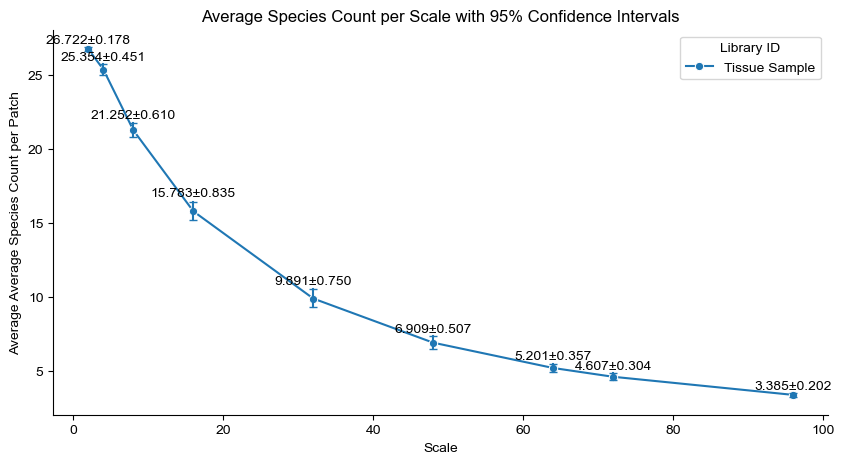

In [34]:
feature_to_plot = 'Average Species Count'
# Calculate mean and confidence interval manually
grouped = data.groupby('Scale')
mean_values = grouped[feature_to_plot].mean()
conf_intervals = grouped[feature_to_plot].apply(lambda x: stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x)-1)) # 95% CI


# Plotting using sns.lineplot
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=data, 
             x='Scale', 
             y=feature_to_plot, 
             style='sample',
             markers=True,
             estimator='mean', 
             err_style="bars", 
             errorbar=("ci", 95),
             err_kws={"capsize":3.0})

# Annotating error bars with their value
for i, (scale, mean, ci) in enumerate(zip(mean_values.index, mean_values, conf_intervals)):
    ax.text(scale, mean + ci, f'{mean:.3f}±{ci:.3f}', color='black', ha='center', va='bottom')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Scale')
plt.ylabel(f"Average {feature_to_plot} per Patch")
plt.title(f'{feature_to_plot} per Scale with 95% Confidence Intervals')
plt.grid(False)
plt.legend(title='Library ID')
plt.show()

## Method 2

In [7]:
def compute_average_distance(adata, k):
    # Extract spatial coordinates
    coordinates = adata.obsm['spatial']
    
    # Initialize the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    
    # Find the k nearest neighbors (including the point itself)
    distances, _ = nbrs.kneighbors(coordinates)
    
    # Compute the average distance up to the k-th neighbor (excluding the point itself)
    avg_distances = np.mean(distances[:, 1:k+1], axis=1)
    
    return avg_distances

In [16]:
k = 3
average_distances = compute_average_distance(adata, k)

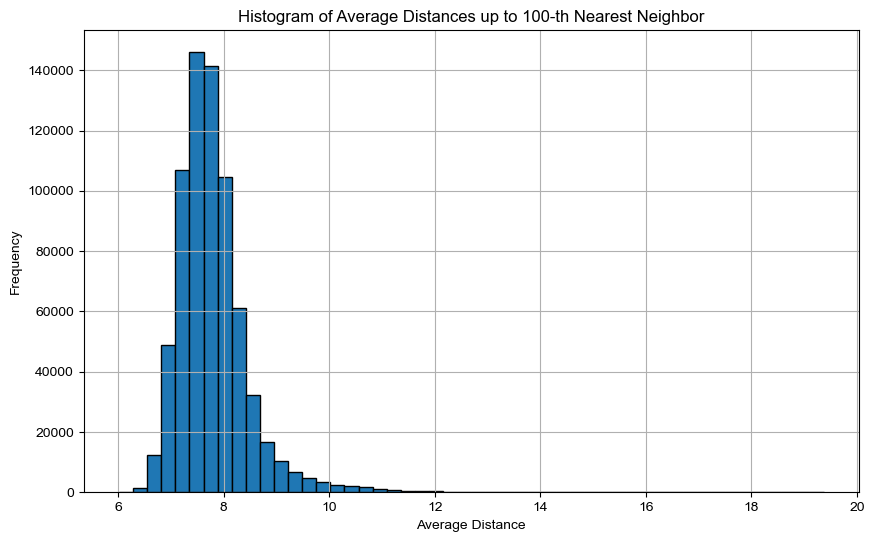

In [17]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(average_distances, bins=50, edgecolor='black')
plt.title(f'Histogram of Average Distances up to {k}-th Nearest Neighbor')
plt.xlabel('Average Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Benchmark Different Spatial Statistics 

## Single sample: Heatmap & Hot/Cold Spots Illustration

In [26]:
test_sample = 'BALBc-1'
scale = 64.0
mode = 'MoranI'

In [27]:
patches_coordinates = msd.generate_patches(adata,'sample',test_sample,scaling_factor=scale, spatial_key='spatial')

In [28]:
len(patches_coordinates)

4096

In [29]:
adata_filtered = adata[adata.obs['sample']==test_sample]
spatial_value = adata_filtered.obsm['spatial']

2.222 per cent patches are empty


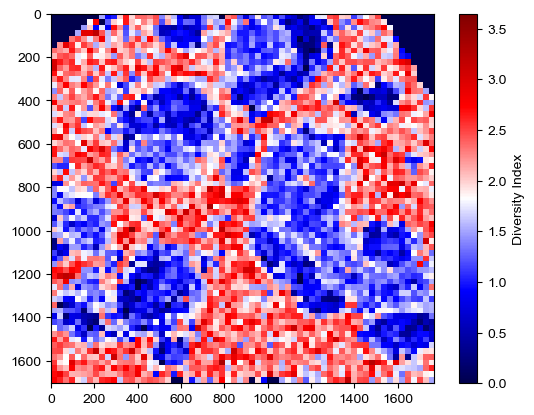

In [30]:
patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=adata, 
                                                            library_key='sample', 
                                                            library_id=test_sample, 
                                                            spatial_key='spatial', 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cell_type', 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid, heatmap_fig = msd.diversity_heatmap(spatial_data=adata,
                                          library_key='sample', 
                                          library_id=test_sample,
                                          spatial_key='spatial',
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=False,
                                          plot=True,
                                          return_fig=True)

In [31]:
print(msd.global_spatial_stats(grid, mode=mode, tissue_only=False))
# (0.002272903595540461, 0.001)
# (0.0022722778759338464, 0.001)
# (0.0019975325182431418, 0.001)

(0.6394073959995283, 0.001)


In [32]:
hotspots, coldspots = msd.local_spatial_stats(grid, mode=mode, p_value=0.01, tissue_only=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)
print(msd.compute_proximity_index(hotspots))
print(msd.compute_proximity_index(coldspots))
# print(sum(doughnuts.flatten()), flush=True)
# print(sum(diamonds.flatten()), flush=True)

# 729
# 572
# 49 islands identified
# 433.85149323404573
# 29 islands identified
# 180.51617955941717

Using MoranI
687
561
48 islands identified
404.2542556417613
28 islands identified
175.64705016023603


In [20]:
# combined_spots = (hotspots * 1) + (coldspots * -1) #+ (doughnuts * 0.5) + (diamonds * -0.5)
# seismic = plt.cm.seismic
# colors = [seismic(0), "lightblue", "white", "salmon", seismic(0.999)]
# cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

combined_spots = (hotspots * 1) + (coldspots * 1) 
seismic = plt.cm.seismic
colors = ['white', 'grey']
cmap = mcolors.LinearSegmentedColormap.from_list("single_color_map", colors)

In [21]:
from scipy.ndimage import center_of_mass

1768.1399999999999 1704.784


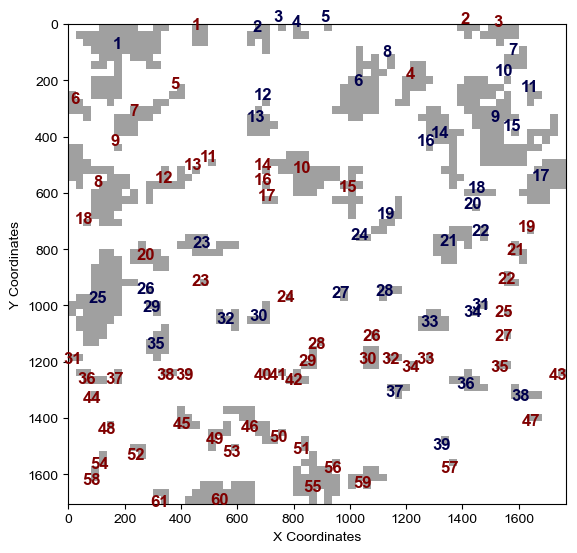

In [22]:
labelled_hot, num_hot_islands = msd.label_islands(hotspots, rook=True)
labelled_cold, num_cold_islands = msd.label_islands(coldspots, rook=True)
    
min_x, min_y = spatial_value.min(axis=0)[0], spatial_value.min(axis=0)[1]
max_x, max_y = spatial_value.max(axis=0)[0], spatial_value.max(axis=0)[1]
width = max_x - min_x
height = max_y - min_y
print(width, height)
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with diversity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Calculate centroids of hot/cold islands and label them
for label in range(1, num_hot_islands + 1):
    positions = np.where(labelled_hot == label)
    if positions[0].size > 0:
        centroid = center_of_mass(labelled_hot == label)
        ax.text(centroid[1]*width/scale, 
                centroid[0]*width/scale, 
                str(label), 
                fontsize=12,
                fontweight='semibold',
                color=seismic(0.999),
                alpha=1.0,
                ha='center', 
                va='bottom')
        
for label in range(1, num_cold_islands + 1):
    positions = np.where(labelled_cold == label)
    if positions[0].size > 0:
        centroid = center_of_mass(labelled_cold == label)
        ax.text(centroid[1]*width/scale, 
                centroid[0]*width/scale, 
                str(label), 
                fontsize=12,
                fontweight='semibold',
                color=seismic(0),
                alpha=1.0,
                ha='center', 
                va='bottom')

plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")

# Plot the heatmap
ax.imshow(grid, cmap=cmap, alpha=0.75, interpolation='none', vmin=0, vmax=1)

# save_path = test_sample + '_' + mode + '_spot_labelled.svg'
# spot_fig.savefig('../figures/mice/'+save_path, dpi=300)

# save_path = test_sample + '_all_spots_labelled.svg'
# spot_fig.savefig('../figures/mice/'+save_path, dpi=300)

## Determine P-value Cut-off

In [17]:
from pysal.lib import weights
from pysal.explore import esda
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FuncFormatter)

In [33]:
n, m = grid.shape
w = weights.lat2W(n, m, rook=False)
lisa = esda.Moran_Local(grid.flatten(), w, transformation='r', permutations=999, seed=42) 

In [34]:
lisa.p_sim

array([0.001, 0.001, 0.001, ..., 0.188, 0.201, 0.293])

In [35]:
lisa.sim.shape

(999, 4096)

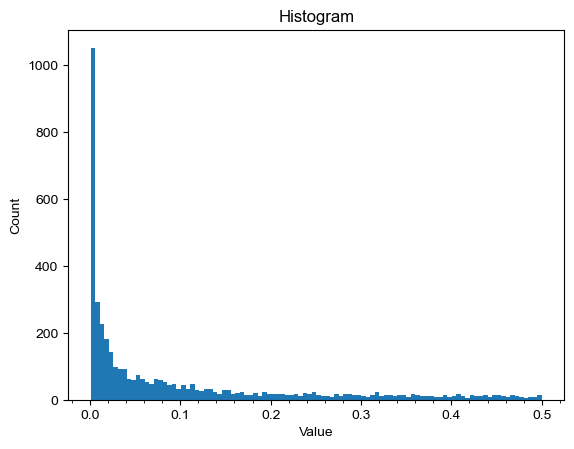

In [36]:
plt.hist(lisa.p_sim, bins=100)  # You can adjust the number of bins
 
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.show()

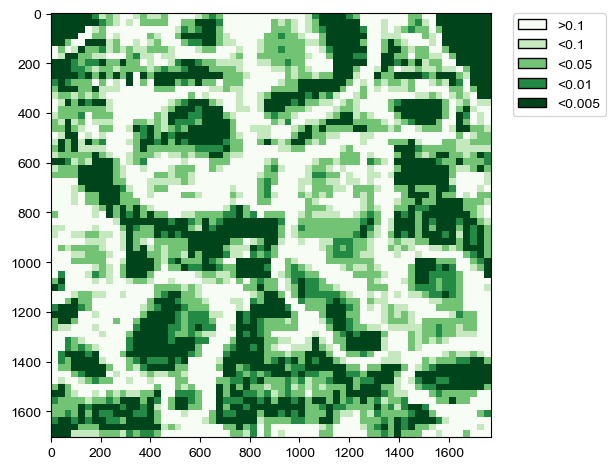

In [37]:
heatmap_fig = msd.pvalue_heatmap(spatial_data=adata,
                                 library_key='sample', 
                                 library_id=test_sample,
                                 spatial_key='spatial',
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=pd.Series(lisa.p_sim),
                                 tissue_only=False,
                                 plot=True,
                                 discrete=True,
                                 return_fig=True)
heatmap_fig.tight_layout()
save_path = '../figures/mice/spleen_'+ test_sample + '_lisa_sigmap.svg'
heatmap_fig.savefig(save_path)

## customized color palette

In [54]:
cell_names = sorted(adata.obs['cell_type'].unique().to_list())

In [55]:
from matplotlib import colors as mcolors
from matplotlib import colormaps

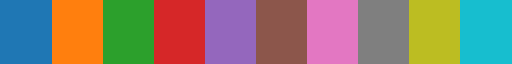

In [56]:
plt.get_cmap('tab10')

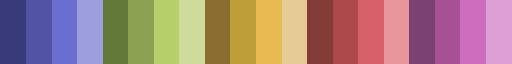

In [57]:
plt.get_cmap('tab20b')

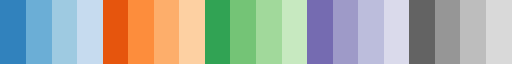

In [58]:
plt.get_cmap('tab20c')

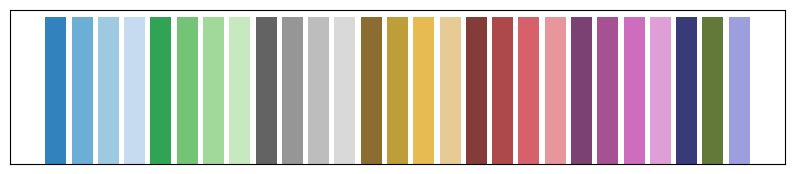

In [59]:
tab10 = colormaps['tab10']
tab20b = colormaps['tab20b']
tab20c = colormaps['tab20c']

# Step 2: Extract specific colors by indexing into the colormap (values from 0 to 1)
# From tab20b: indices 8 to 19
colors_from_tab20b = [tab20b(i) for i in range(8, 20)] + [tab20b(0),tab20b(4),tab20b(3)]
# From tab20c: indices 0-3, 8-11, and 16-19
colors_from_tab20c = [tab20c(i) for i in range(4)] + [tab20c(i) for i in range(8, 12)] + [tab20c(i) for i in range(16, 20)]


# Step 3: Combine the colors into a custom palette
custom_palette = colors_from_tab20c + colors_from_tab20b

# Step 4: Use the custom palette in a plot
plt.figure(figsize=(10, 2))
for i, color in enumerate(custom_palette):
    plt.bar(i, 1, color=color)

plt.xticks([])
plt.yticks([])
plt.show()


In [60]:
colors_hex = [mcolors.rgb2hex(color) for color in custom_palette]
color_dict = dict(zip(cell_names, colors_hex))
color_dict['CD4(+) T cells'] = mcolors.rgb2hex(tab10(1))
color_dict['CD8(+) T cells'] = '#31a354'
color_dict['CD106(+)CD16/32(-)Ly6C(+)CD31(+)']= '#e7cb94'
color_dict['F4/80(+) mphs'] = mcolors.rgb2hex(tab20c(12))
color_dict['FDCs'] = mcolors.rgb2hex(tab10(3))
color_dict['CD4(+)MHCII(+)'] = '#637939'
color_dict['CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma'] = mcolors.rgb2hex(tab10(9))
color_dict['noid'] = '#8c6d31'

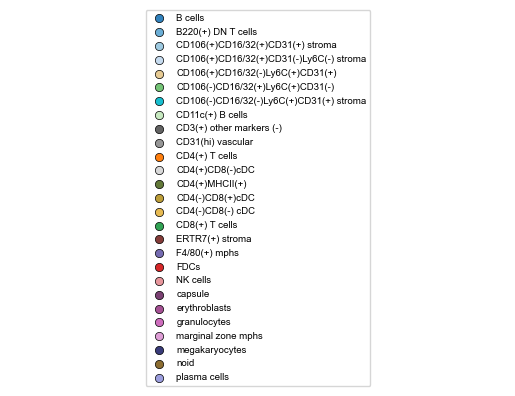

In [61]:
fig, ax = plt.subplots()

# Create a scatter plot for each item in the dictionary
for label, color in color_dict.items():
    ax.scatter([], [], c=color, label=label, marker='o',edgecolors='black', linewidths=0.5)

# Create the legend
ax.legend(loc='center', ncol=1, fontsize='x-small')

# Hide axes
ax.axis('off')

# save_path = 'cellType' + '_legend.jpeg'
# plt.savefig('../figures/mice/'+save_path, dpi=300, bbox_inches='tight')
# save_path = 'cellType' + '_legend.svg'
# plt.savefig('../figures/mice/'+save_path, dpi=300, bbox_inches='tight')
plt.show()

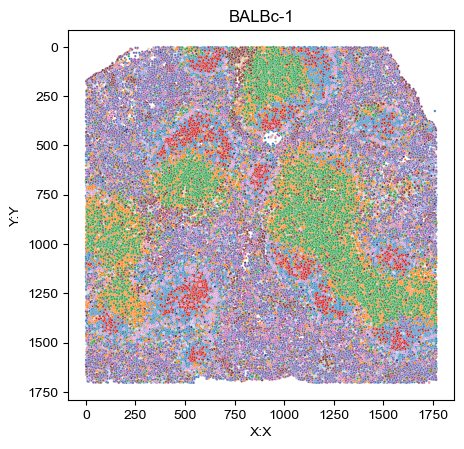

In [65]:
protein_region = adata[adata.obs['sample']==test_sample].obs[['cell_type', 'sample']].reset_index(drop=True)
protein_region['X:X'] = adata[adata.obs['sample']==test_sample].obsm['spatial'][:,0]
protein_region['Y:Y'] = adata[adata.obs['sample']==test_sample].obsm['spatial'][:,1]

x_coords = protein_region['X:X']
y_coords = protein_region['Y:Y']
width = x_coords.max(axis=0) - x_coords.min(axis=0)
height = y_coords.max(axis=0) - y_coords.min(axis=0)
w, h = figaspect(height/width)
fig, ax = plt.subplots(1, 1, figsize=(w, h))

sns.scatterplot(data=protein_region, x="X:X", y="Y:Y", hue="cell_type", palette=color_dict, s=3, legend='full', ax=ax, rasterized=True)
ax.set_title(test_sample)
ax.legend(bbox_to_anchor=(1.5, -0.1), ncol=3, fontsize=14)
ax.get_legend().remove()
ax.invert_yaxis()
save_path = test_sample + '_celltype.svg'
fig.savefig('../figures/mice/'+save_path, dpi=300)
plt.show()

## island composition

In [27]:
from scipy.spatial.distance import pdist, squareform

In [84]:
Hot = False

In [85]:
if Hot:
    print(f"Aggregating hot islands composition")
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
    island_comp = aggregate_spot_compositions(labelled_hot, patches_comp)
else:
    print(f"Aggregating cold islands composition")
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]
    island_comp = aggregate_spot_compositions(labelled_cold, patches_comp)
island_comp.head()

Aggregating cold islands composition


cell_type,B cells,B220(+) DN T cells,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,CD106(+)CD16/32(-)Ly6C(+)CD31(+),CD4(+) T cells,CD4(+)CD8(-)cDC,CD4(-)CD8(+)cDC,CD4(-)CD8(-) cDC,CD8(+) T cells,ERTR7(+) stroma,F4/80(+) mphs,FDCs,NK cells,erythroblasts,marginal zone mphs,noid
Island_1,654.0,555.0,15.0,3.0,99.0,12.0,3.0,5.0,24.0,3.0,4.0,7.0,2.0,6.0,9.0,10.0
Island_2,7.0,112.0,4.0,NaN,57.0,1.0,NaN,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Island_3,NaN,9.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
Island_4,1.0,39.0,2.0,NaN,18.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
Island_5,NaN,16.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


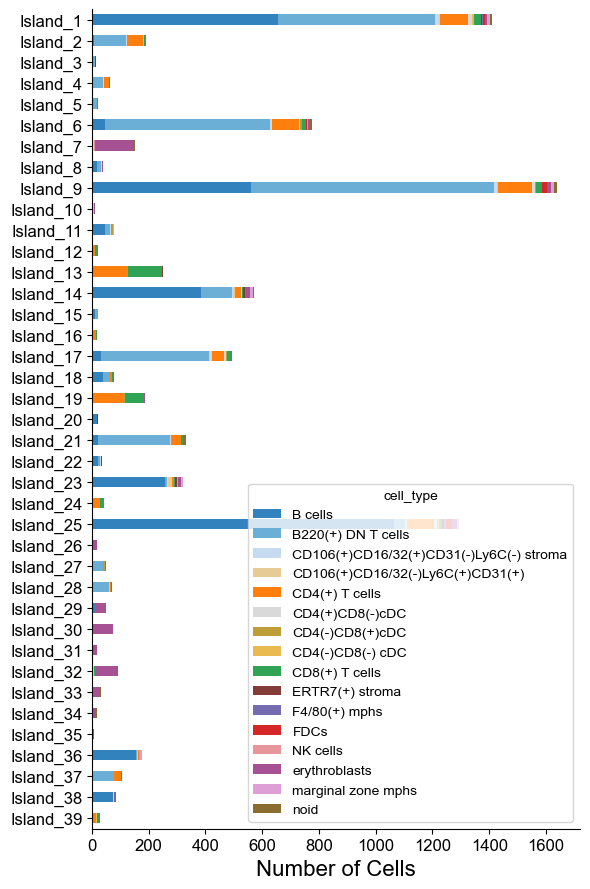

In [86]:
# Extract colors in the order of DataFrame columns
colors = [color_dict[col] for col in island_comp.columns]
ax = island_comp.plot(kind='barh', stacked=True, color=colors, figsize=(6,9))

# Set plot title, axis labels, and legend
plt.title('', fontsize=16)
plt.xlabel('Number of Cells', fontsize=16)
plt.ylabel('')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.xaxis.set_visible(False)
ax.invert_yaxis()

# Show the plot with a clean layout
plt.tight_layout()
if Hot:
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_hot_island_composition.png')
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_hot_island_composition.svg')
else:
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_cold_island_composition.png')
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_cold_island_composition.svg')
plt.show()

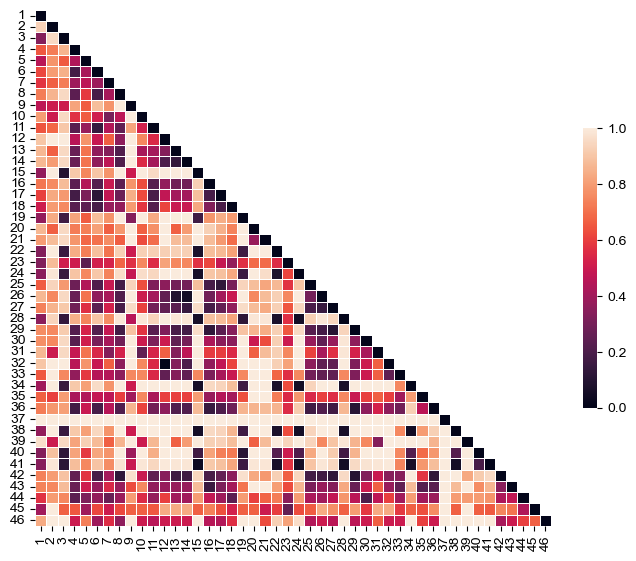

In [89]:
island_comp = island_comp.div(island_comp.sum(axis=1), axis=0)
island_comp_filled = island_comp.fillna(0)

# Calculate Bray-Curtis distance
distances = pdist(island_comp_filled.values, metric='braycurtis')

# Convert the condensed distance matrix to a square matrix
distance_matrix = squareform(distances)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_matrix, dtype=bool),k=1)

# Set up the matplotlib figure
plt.figure(figsize=(7, 6))
axis_labels = np.arange(1, len(distance_matrix)+1)
sns.heatmap(distance_matrix, 
            mask=mask, 
            cmap='rocket', 
            vmin=0.0,
            vmax=1.0, 
            annot=False, 
            square=True, 
            linewidths=.5, 
            xticklabels=axis_labels, 
            yticklabels=axis_labels,
            cbar_kws={"shrink": .5})

# Title and labels might need adjustments
plt.title('')
plt.tight_layout()
if Hot:
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_hot_island_composition_similarity.svg')
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_hot_island_composition_similarity.png')
else:
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_cold_island_composition_similarity.svg')
    plt.savefig('../figures/mice/'+mode+'_'+test_sample+'_cold_island_composition_similarity.png')
plt.show()


In [72]:
len(distance_matrix)

53

In [73]:
island_comp_filled

cell_type,B cells,B220(+) DN T cells,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,CD106(+)CD16/32(-)Ly6C(+)CD31(+),CD4(+) T cells,CD4(+)CD8(-)cDC,CD4(+)MHCII(+),CD4(-)CD8(+)cDC,CD4(-)CD8(-) cDC,CD8(+) T cells,ERTR7(+) stroma,F4/80(+) mphs,erythroblasts,noid
Island_1,0.073529,0.544118,0.040441,0.003676,0.165441,0.036765,0.007353,0.011029,0.033088,0.033088,0.007353,0.003676,0.022059,0.018382
Island_2,0.693548,0.064516,0.016129,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048387,0.112903,0.016129
Island_3,0.062112,0.000000,0.062112,0.000000,0.037267,0.012422,0.006211,0.018634,0.006211,0.018634,0.000000,0.031056,0.726708,0.018634
Island_4,0.640000,0.120000,0.000000,0.040000,0.080000,0.040000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000
Island_5,0.047619,0.619048,0.009524,0.000000,0.209524,0.028571,0.000000,0.000000,0.009524,0.047619,0.019048,0.009524,0.000000,0.000000
Island_6,0.500000,0.363636,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000
Island_7,0.619048,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.047619,0.095238,0.095238,0.047619,0.000000
Island_8,0.082474,0.264605,0.037801,0.000000,0.381443,0.041237,0.000000,0.006873,0.003436,0.161512,0.000000,0.000000,0.006873,0.013746
Island_9,0.343750,0.093750,0.031250,0.052083,0.104167,0.010417,0.000000,0.000000,0.000000,0.041667,0.041667,0.083333,0.197917,0.000000
Island_10,0.650000,0.050000,0.000000,0.100000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000


In [38]:
island_comp_filled.iloc[17]

cell_type
B cells               0.807592
B220(+) DN T cells    0.001309
CD4(+) T cells        0.028796
CD4(+)CD8(-)cDC       0.001309
CD8(+) T cells        0.013089
F4/80(+) mphs         0.002618
FDCs                  0.120419
erythroblasts         0.000000
marginal zone mphs    0.020942
noid                  0.003927
Name: Island_18, dtype: float64

In [37]:
island_comp_filled.iloc[7]

cell_type
B cells               0.791054
B220(+) DN T cells    0.000000
CD4(+) T cells        0.041054
CD4(+)CD8(-)cDC       0.000613
CD8(+) T cells        0.008578
F4/80(+) mphs         0.005515
FDCs                  0.139706
erythroblasts         0.001838
marginal zone mphs    0.010417
noid                  0.001225
Name: Island_8, dtype: float64

In [39]:
spatial.distance.braycurtis(island_comp_filled.iloc[17], island_comp_filled.iloc[7])

0.036280284365054934

In [39]:
spatial.distance.braycurtis([1,1,1,1,1], [100,100,100,100,100])

0.9801980198019802

In [40]:
pdist([island_comp_filled.iloc[17], island_comp_filled.iloc[7]], metric='braycurtis')

array([0.03628028])

## All samples

In [10]:
Hot = True
mode = 'MoranI'
library_names = ['BALBc', 'MRL'] 
library_ids = [['BALBc-1', 'BALBc-2', 'BALBc-3'], ['MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']]
comp_results = []
comp_results_mice = []
moran_results = []

comb_freq_results = []
comb_freq_results_mice = []

for library, library_name in zip(library_ids, library_names):
    total_comp_dict, global_morans, spot_comb_dict = msd.diversity_clustering(spatial_data=adata, 
                                                                              scale=64.0, 
                                                                              library_key='sample',
                                                                              library_ids=library, 
                                                                              spatial_key='spatial',
                                                                              cluster_key='cell_type',
                                                                              hotspot=Hot,
                                                                              whole_tissue=True,
                                                                              top=None,
                                                                              selected_comb=None,
                                                                              mode=mode,
                                                                              metric='Shannon Diversity')

    # Concatenate all the merged_series and sum across rows
    total_merged_series = pd.concat(total_comp_dict.values(), axis=1).sum(axis=1)
    comp_results.append(total_merged_series)
    comb_freq_results.append(spot_comb_dict)
    
    # Store Moran's I 
    moran_results.append(global_morans)
    
    # Calculate cell-type/combination freq in hotspots
    comp_mice = pd.DataFrame()
    comb_mice = pd.DataFrame()
    
    for key in total_comp_dict.keys():
        comp_mice = append_series_to_df(comp_mice, (total_comp_dict[key]/total_comp_dict[key].sum(axis=0)), key)
        comb_mice = append_series_to_df(comb_mice, spot_comb_dict[key], key)
        
    comp_mice = comp_mice.T    
    comp_mice['Condition'] = library_name 
    comp_results_mice.append(comp_mice.fillna(0))
    
    comb_mice = comb_mice.T
    comb_mice['Condition'] = library_name
    comb_freq_results_mice.append(comb_mice.fillna(0))

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
Considering whole tissue
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
Considering whole tissue
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
Considering whole tissue
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
Considering whole tissue
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
Considering whole tissue
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
Considering whole tissue
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
Considering whole t

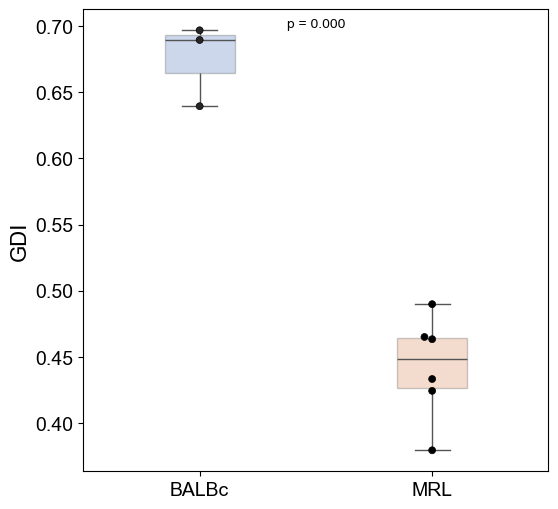

In [11]:
# Extract data for boxplot
balbc_data = [v[0] for k, v in moran_results[0].items()]
mrl_data = [v[0] for k, v in moran_results[1].items()]

# Mann-Whitney U test
# stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data)
stat, p_value = stats.ttest_ind(balbc_data, mrl_data, equal_var=False)

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6)) 
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)

plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("GDI", fontsize=16)
# plt.title('Box plot of BALBc vs MRL', fontsize=18)

# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')
save_path = mode + '_' + 'GDI.svg'
fig = plt.gcf()
# fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

# More landscape metrics

In [20]:
# Use Alpha shape to draw polygons as new shape/boudary of hot/cold islands
import alphashape
from shapely.geometry import Polygon
from esda import shape as shapestats 

In [ ]:
np.nonzero(np.array([[False, False, False],
       [ True,  True,  True],
       [ True,  True,  True]]).flatten())[0]

In [22]:
def compute_island_boundary(adata, library_key, library_id, labelled, coordinates, save_key, spatial_key='spatial'):
    """
    Aggregate compositions of spots that belong to the same island.

    Parameters:
    - adata: anndata.AnnData: The spatial data to be used.
    - spots: Boolean array indicating whether each patch is a spot.
    - labelled: Array of the same shape as 'spots', where each component (island) has a unique label.

    Returns:
    - modifies the ``adata`` and stores the results.
    """ 
    boundaries = {}
    adata_filtered = adata[adata.obs[library_key] == library_id]
    
    # Iterate over each unique label (island)
    for label in range(1, np.max(labelled) + 1):
        # Find indices where the current label is present
        indices = (labelled == label)
        # print(indices)
        # print(np.nonzero(indices))
        # map quadrat coordinates back to cell point coordinates
        points = []
        for index in np.nonzero(indices.flatten())[0]:
            x0, y0, x1, y1 = coordinates[index]
            new_points = (adata_filtered[
                (adata_filtered.obsm[spatial_key][:, 0] >= x0) & 
                (adata_filtered.obsm[spatial_key][:, 0] < x1) & 
                (adata_filtered.obsm[spatial_key][:, 1] >= y0) & 
                (adata_filtered.obsm[spatial_key][:, 1] < y1)
            ].obsm[spatial_key].copy())
            points.extend(list(map(tuple, new_points)))
        # print(f'Island {label} has {len(points)} points')
        
        # Determine the optimized alpha parameter
        # alpha = alphashape.optimizealpha(points) # theres an internal bug
        alpha = 0.1
        
        # Generate the alpha shape
        if points:  # Ensure points exist to generate the alpha shape
            alpha_shape = alphashape.alphashape(points, alpha)
            boundaries[f"{save_key}_{label}_shape"] = alpha_shape
        else:
            print(f"Warning: Island {label} has no valid points.")
            
    adata.uns[f"{library_id}_{save_key}_shape"] = {"boundary": boundaries}

    


In [23]:
compute_island_boundary(adata=adata, 
                        library_key='sample',
                        library_id=test_sample,
                        labelled=labelled_hot, 
                        coordinates=patches_coordinates, 
                        save_key='hot_islands')

compute_island_boundary(adata=adata, 
                        library_key='sample',
                        library_id=test_sample,
                        labelled=labelled_cold, 
                        coordinates=patches_coordinates, 
                        save_key='cold_islands')

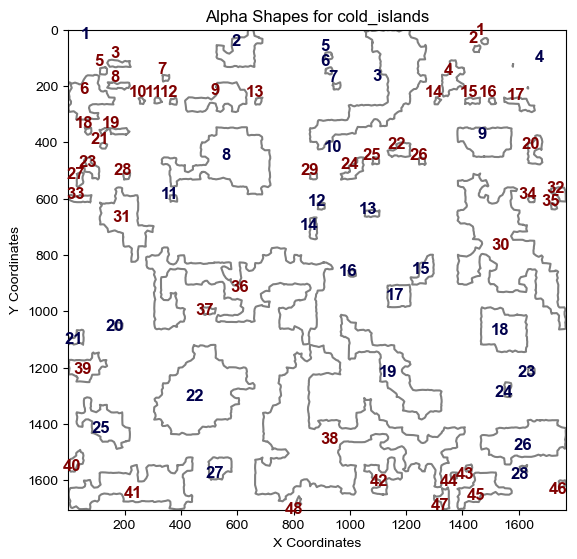

In [25]:
# Create a plot
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

save_key = "hot_islands"
shape_data = adata.uns[f"{test_sample}_{save_key}_shape"]["boundary"]
for key in shape_data.keys():
    boundary = shape_data[key]

    # Check if the boundary is a Polygon or MultiPolygon
    if isinstance(boundary, Polygon):
        x, y = boundary.exterior.xy
        ax.plot(x, y, label=key, color='grey')
    elif boundary.geom_type == 'MultiPolygon':
        for poly in boundary.geoms:
            x, y = poly.exterior.xy
            ax.plot(x, y, label=key, color='grey')
            
# Calculate centroids of hot/cold islands and label them
for label in range(1, num_hot_islands + 1):
    positions = np.where(labelled_hot == label)
    if positions[0].size > 0:
        centroid = center_of_mass(labelled_hot == label)
        ax.text(centroid[1]*width/scale, 
                centroid[0]*width/scale, 
                str(label), 
                fontsize=12,
                fontweight='semibold',
                color=seismic(0.999),
                alpha=1.0,
                ha='center', 
                va='bottom')

save_key = "cold_islands"
shape_data = adata.uns[f"{test_sample}_{save_key}_shape"]["boundary"]
for key in shape_data.keys():
    boundary = shape_data[key]

    # Check if the boundary is a Polygon or MultiPolygon
    if isinstance(boundary, Polygon):
        x, y = boundary.exterior.xy
        ax.plot(x, y, label=key, color='grey')
    elif boundary.geom_type == 'MultiPolygon':
        for poly in boundary.geoms:
            x, y = poly.exterior.xy
            ax.plot(x, y, label=key, color='grey')
for label in range(1, num_cold_islands + 1):
    positions = np.where(labelled_cold == label)
    if positions[0].size > 0:
        centroid = center_of_mass(labelled_cold == label)
        ax.text(centroid[1]*width/scale, 
                centroid[0]*width/scale, 
                str(label), 
                fontsize=12,
                fontweight='semibold',
                color=seismic(0),
                alpha=1.0,
                ha='center', 
                va='bottom')
        
# Set plot title, labels, and legend
ax.set_title(f"Alpha Shapes for {save_key}")
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
ax.invert_yaxis()
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")

# Save and Show the plot
plt.savefig('../figures/mice/alpha_shape_islands_' + test_sample + '.svg')
plt.show()


In [29]:
shapestats.fractal_dimension(adata.uns[f"{test_sample}_hot_islands_shape"]["boundary"]['hot_islands_19_shape'], support='square')

array([1.1241601])

In [32]:
shapestats.shape_index(adata.uns[f"{test_sample}_hot_islands_shape"]["boundary"]['hot_islands_19_shape'])

array([0.49354294])

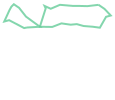

In [33]:
adata.uns[f"{test_sample}_hot_islands_shape"]["boundary"]['hot_islands_19_shape'].boundary

## All samples

In [33]:
mode='MoranI'
scale=64.0
library_ids = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']
for library_id in library_ids:
    patches_coordinates = msd.generate_patches(adata,
                                               'sample',
                                               library_id,
                                               scaling_factor=scale, 
                                               spatial_key='spatial')

    patch_indices, patches_comp = msd.calculate_diversity_index(spatial_data=adata, 
                                                                library_key='sample', 
                                                                library_id=library_id, 
                                                                spatial_key='spatial', 
                                                                patches=patches_coordinates, 
                                                                cluster_key='cell_type', 
                                                                metric='Shannon Diversity', 
                                                                return_comp=True)

    grid = msd.diversity_heatmap(spatial_data=adata,
                                 library_key='sample', 
                                 library_id=library_id,
                                 spatial_key='spatial',
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=patch_indices,
                                 tissue_only=False,
                                 plot=False,
                                 return_fig=True)
    
    hotspots, coldspots = msd.local_spatial_stats(grid, mode=mode, p_value=0.01, tissue_only=False)
    
    labelled_hot, num_hot_islands = msd.label_islands(hotspots, rook=True)
    labelled_cold, num_cold_islands = msd.label_islands(coldspots, rook=True)

    # hot islands
    compute_island_boundary(adata=adata, 
                            library_key='sample',
                            library_id=library_id,
                            labelled=labelled_hot, 
                            coordinates=patches_coordinates, 
                            save_key='hot_islands')
    # cold islands
    compute_island_boundary(adata=adata, 
                            library_key='sample',
                            library_id=library_id,
                            labelled=labelled_cold, 
                            coordinates=patches_coordinates, 
                            save_key='cold_islands')
adata

2.222 per cent patches are empty
5.542 per cent patches are empty
7.812 per cent patches are empty
0.708 per cent patches are empty
0.708 per cent patches are empty
0.220 per cent patches are empty
0.220 per cent patches are empty
0.098 per cent patches are empty
0.000 per cent patches are empty


AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors', 'MRL-4_hot_islands_shape', 'BALBc-1_hot_islands_shape', 'BALBc-1_cold_islands_shape', 'BALBc-2_hot_islands_shape', 'BALBc-2_cold_islands_shape', 'BALBc-3_hot_islands_shape', 'BALBc-3_cold_islands_shape', 'MRL-4_cold_islands_shape', 'MRL-5_hot_islands_shape', 'MRL-5_cold_islands_shape', 'MRL-6_hot_islands_shape', 'MRL-6_cold_islands_shape', 'MRL-7_hot_islands_shape', 'MRL-7_cold_islands_shape', 'MRL-8_hot_islands_shape', 'MRL-8_cold_islands_shape', 'MRL-9_hot_islands_shape', 'MRL-9_cold_islands_shape'
    obsm: 'blanks', 'spatial'

In [34]:
np.isnan(shapestats.fractal_dimension(adata.uns[f"MRL-7_cold_islands_shape"]["boundary"]['cold_islands_34_shape'])) 

array([ True])

In [33]:
Hot = True
shape_metric = 'Average_Fractal_Dimension'
library_ids = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']
shape_metrics = pd.DataFrame(columns=['Sample', shape_metric])

for library_id in library_ids:
    if Hot:
        boundaries = adata.uns[f'{library_id}_hot_islands_shape']["boundary"]
    else:
        boundaries = adata.uns[f'{library_id}_cold_islands_shape']["boundary"]
        
    sample_fractal_dim = []  
    for key in boundaries.keys():
        if boundaries[key]:
            fractal_dim = shapestats.fractal_dimension(boundaries[key])[0]
            if not np.isnan(fractal_dim):
                sample_fractal_dim.append(fractal_dim)
    
    average_fractal_dim = sum(sample_fractal_dim) / len(sample_fractal_dim)

    
    shape_metrics.loc[len(shape_metrics.index)] = [library_id, average_fractal_dim] 
    
shape_metrics.set_index('Sample', inplace=True)
shape_metrics

,Average_Fractal_Dimension
Sample,
BALBc-1,1.075643
BALBc-2,1.078811
BALBc-3,1.081983
MRL-4,1.080385
MRL-5,1.101318
MRL-6,1.070869
MRL-7,1.090362
MRL-8,1.074304
MRL-9,1.065831


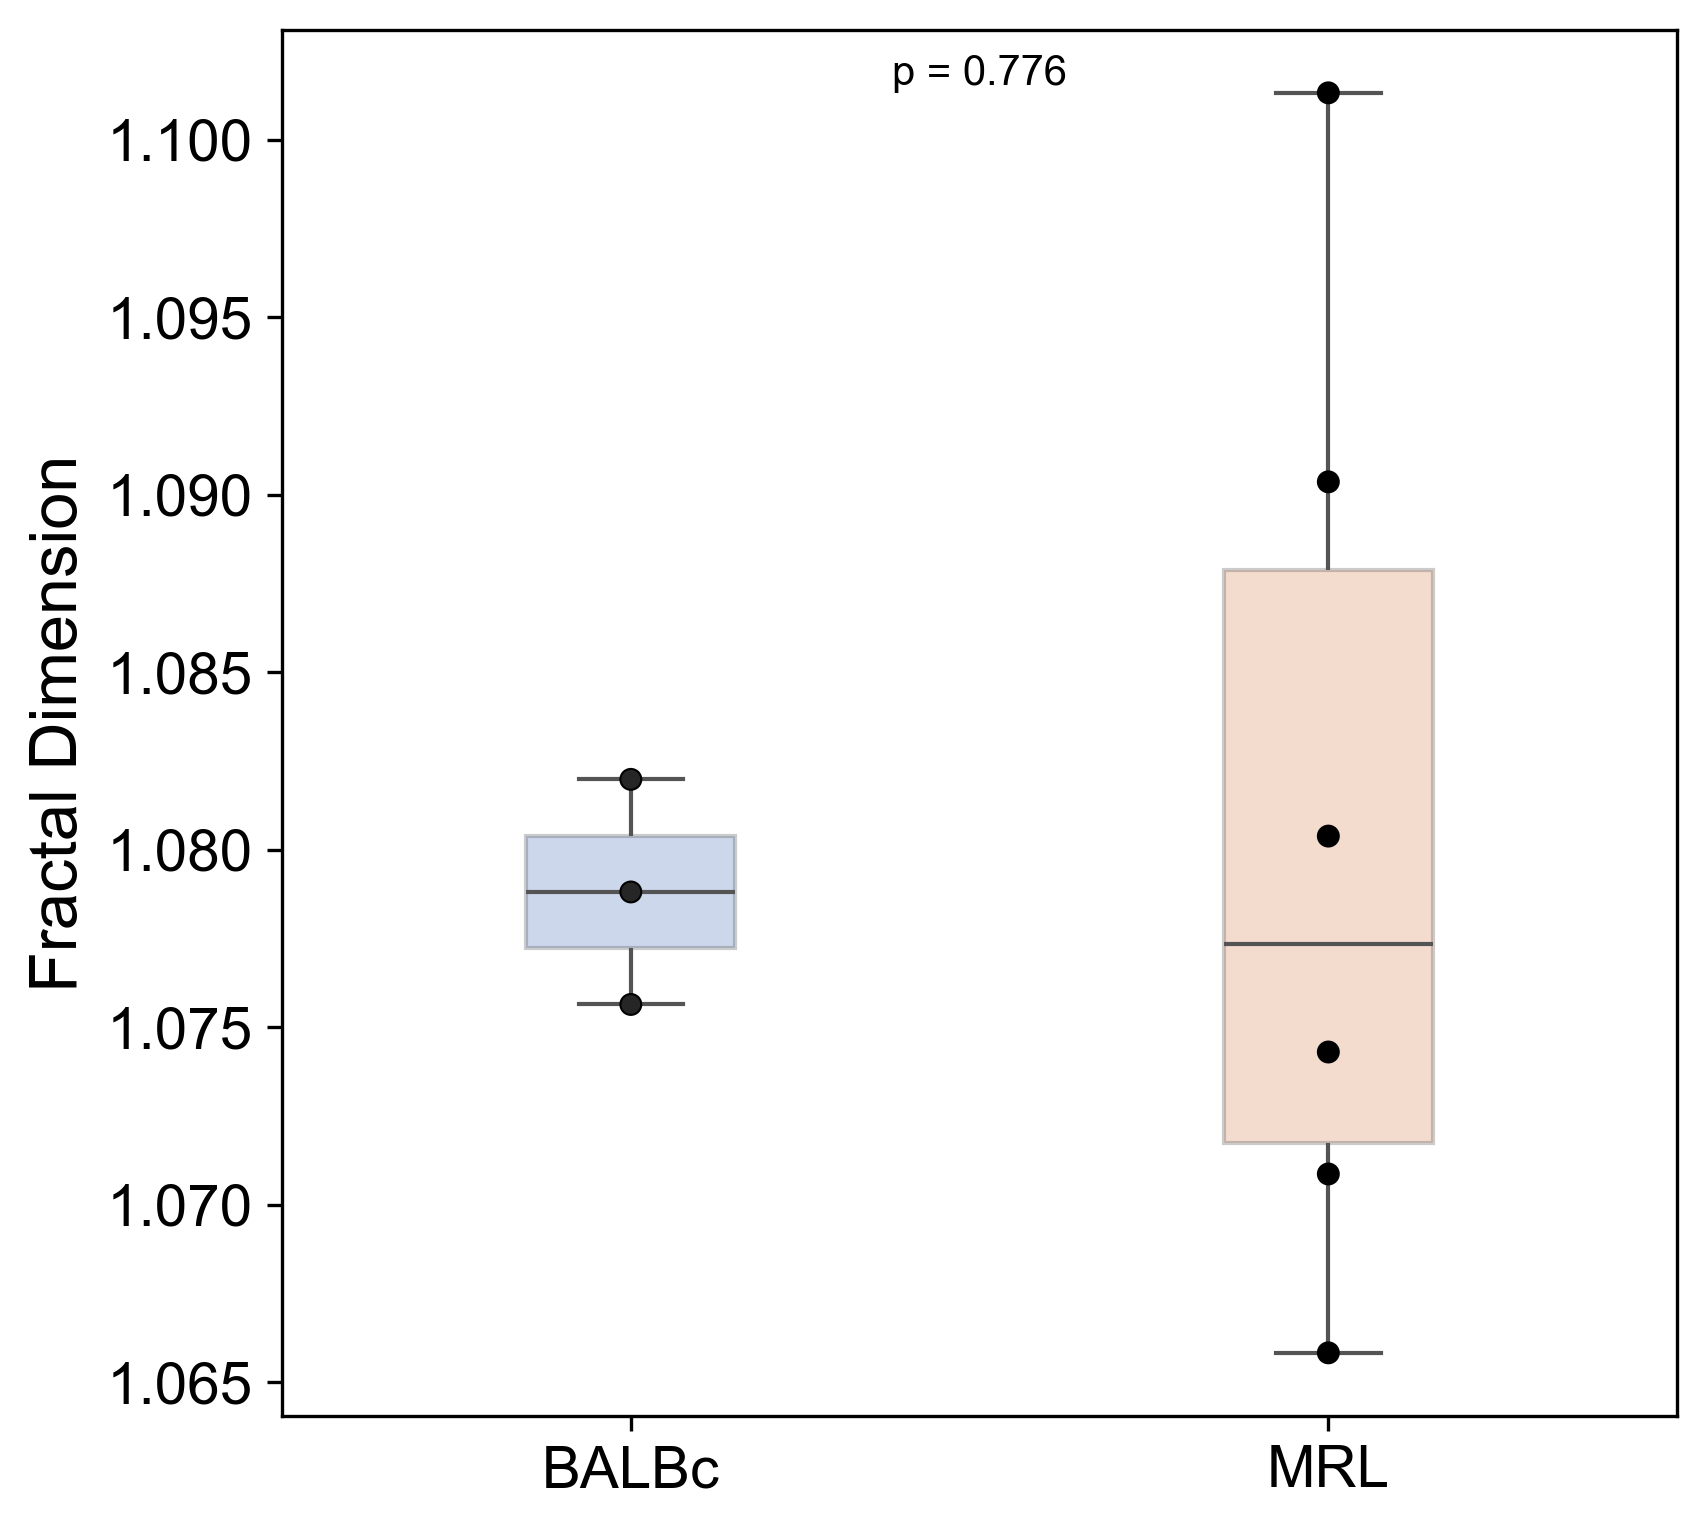

In [34]:
if Hot:
    save_path = 'HotIslands_fractal_dim.svg'
else:
    save_path = 'ColdIslands_fractal_dim.svg'
    
# Extract data for boxplot
balbc_data = shape_metrics.iloc[:3]['Average_Fractal_Dimension'].tolist() 
mrl_data = shape_metrics.iloc[3:]['Average_Fractal_Dimension'].tolist()  

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(balbc_data, mrl_data,equal_var=False) # p=0.01381

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Fractal Dimension", fontsize=16)
plt.title('', fontsize=18)


# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

In [40]:
Hot = False
shape_metric = 'Average_Shape_Index'
library_ids = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']
shape_metrics = pd.DataFrame(columns=['Sample', shape_metric])

for library_id in library_ids:
    if Hot:
        boundaries = adata.uns[f'{library_id}_hot_islands_shape']["boundary"]
    else:
        boundaries = adata.uns[f'{library_id}_cold_islands_shape']["boundary"]
        
    sample_shape_index = []  
    for key in boundaries.keys():
        if boundaries[key]:
            shape_index = shapestats.shape_index(boundaries[key])[0]
            if not np.isnan(shape_index):
                sample_shape_index.append(shape_index)
    
    average_shape_index = sum(sample_shape_index) / len(sample_shape_index)

    
    shape_metrics.loc[len(shape_metrics.index)] = [library_id, average_shape_index] 
    
shape_metrics.set_index('Sample', inplace=True)
shape_metrics

,Average_Shape_Index
Sample,
BALBc-1,0.679758
BALBc-2,0.685737
BALBc-3,0.608847
MRL-4,0.701828
MRL-5,0.667889
MRL-6,0.664242
MRL-7,0.662883
MRL-8,0.656270
MRL-9,0.685524


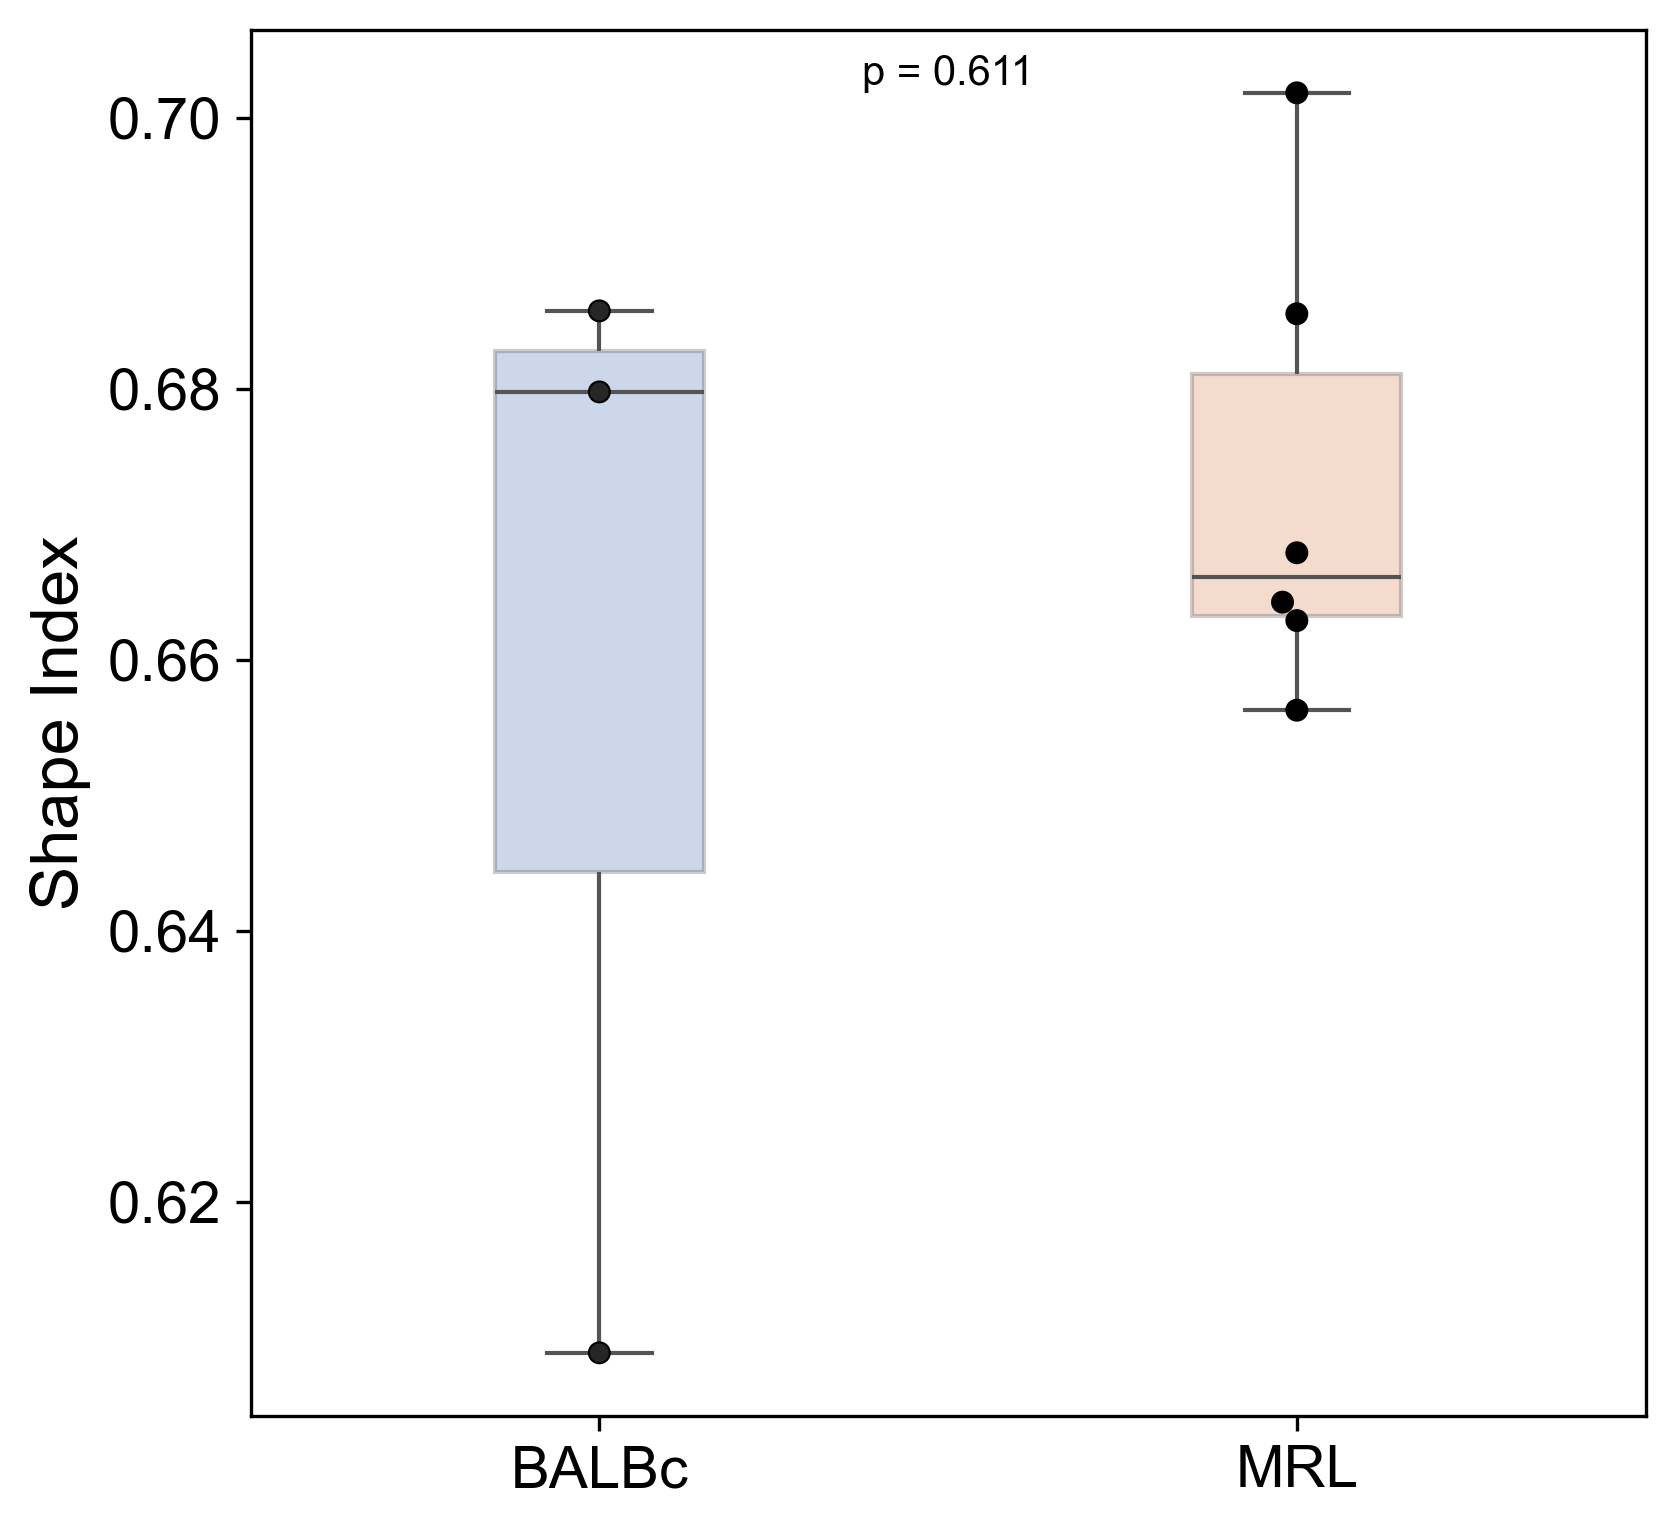

In [41]:
if Hot:
    save_path = 'HotIslands_shape_index.svg'
else:
    save_path = 'ColdIslands_shape_index.svg'
    
# Extract data for boxplot
balbc_data = shape_metrics.iloc[:3]['Average_Shape_Index'].tolist() 
mrl_data = shape_metrics.iloc[3:]['Average_Shape_Index'].tolist()  

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(balbc_data, mrl_data,equal_var=False) # p=0.01381

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Shape Index", fontsize=16)
plt.title('', fontsize=18)


# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

## Calculate Proximity Index

In [22]:
Hot = False
p_value = 0.05
mode = 'MoranI'
library_names = ['BALBc', 'MRL'] 
library_ids = [['BALBc-1', 'BALBc-2', 'BALBc-3'], ['MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9']]
PX_results = []


for library, library_name in zip(library_ids, library_names):
    proximity_I = msd.sample_proximity(spatial_data=adata, 
                                       scale=64.0, 
                                       library_key='sample',
                                       library_ids=library, 
                                       spatial_key='spatial',
                                       cluster_key='cell_type',
                                       hotspot=Hot,
                                       mode=mode,
                                       p_value=p_value,
                                       metric='Shannon Diversity')
    # Store PX 
    PX_results.append(proximity_I)


Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Using MoranI
Region BALBc-1 contains 961 diversity coldspots
30 islands identified
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Using MoranI
Region BALBc-2 contains 1072 diversity coldspots
24 islands identified
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Using MoranI
Region BALBc-3 contains 856 diversity coldspots
30 islands identified
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Using MoranI
Region MRL-4 contains 806 diversity coldspots
46 islands identified
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Using MoranI
Region MRL-5 contains 806 diversity coldspots
42 islands identified
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Using MoranI
Region MRL-6 contains 687 diversity coldspots
38 islands identified
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are emp

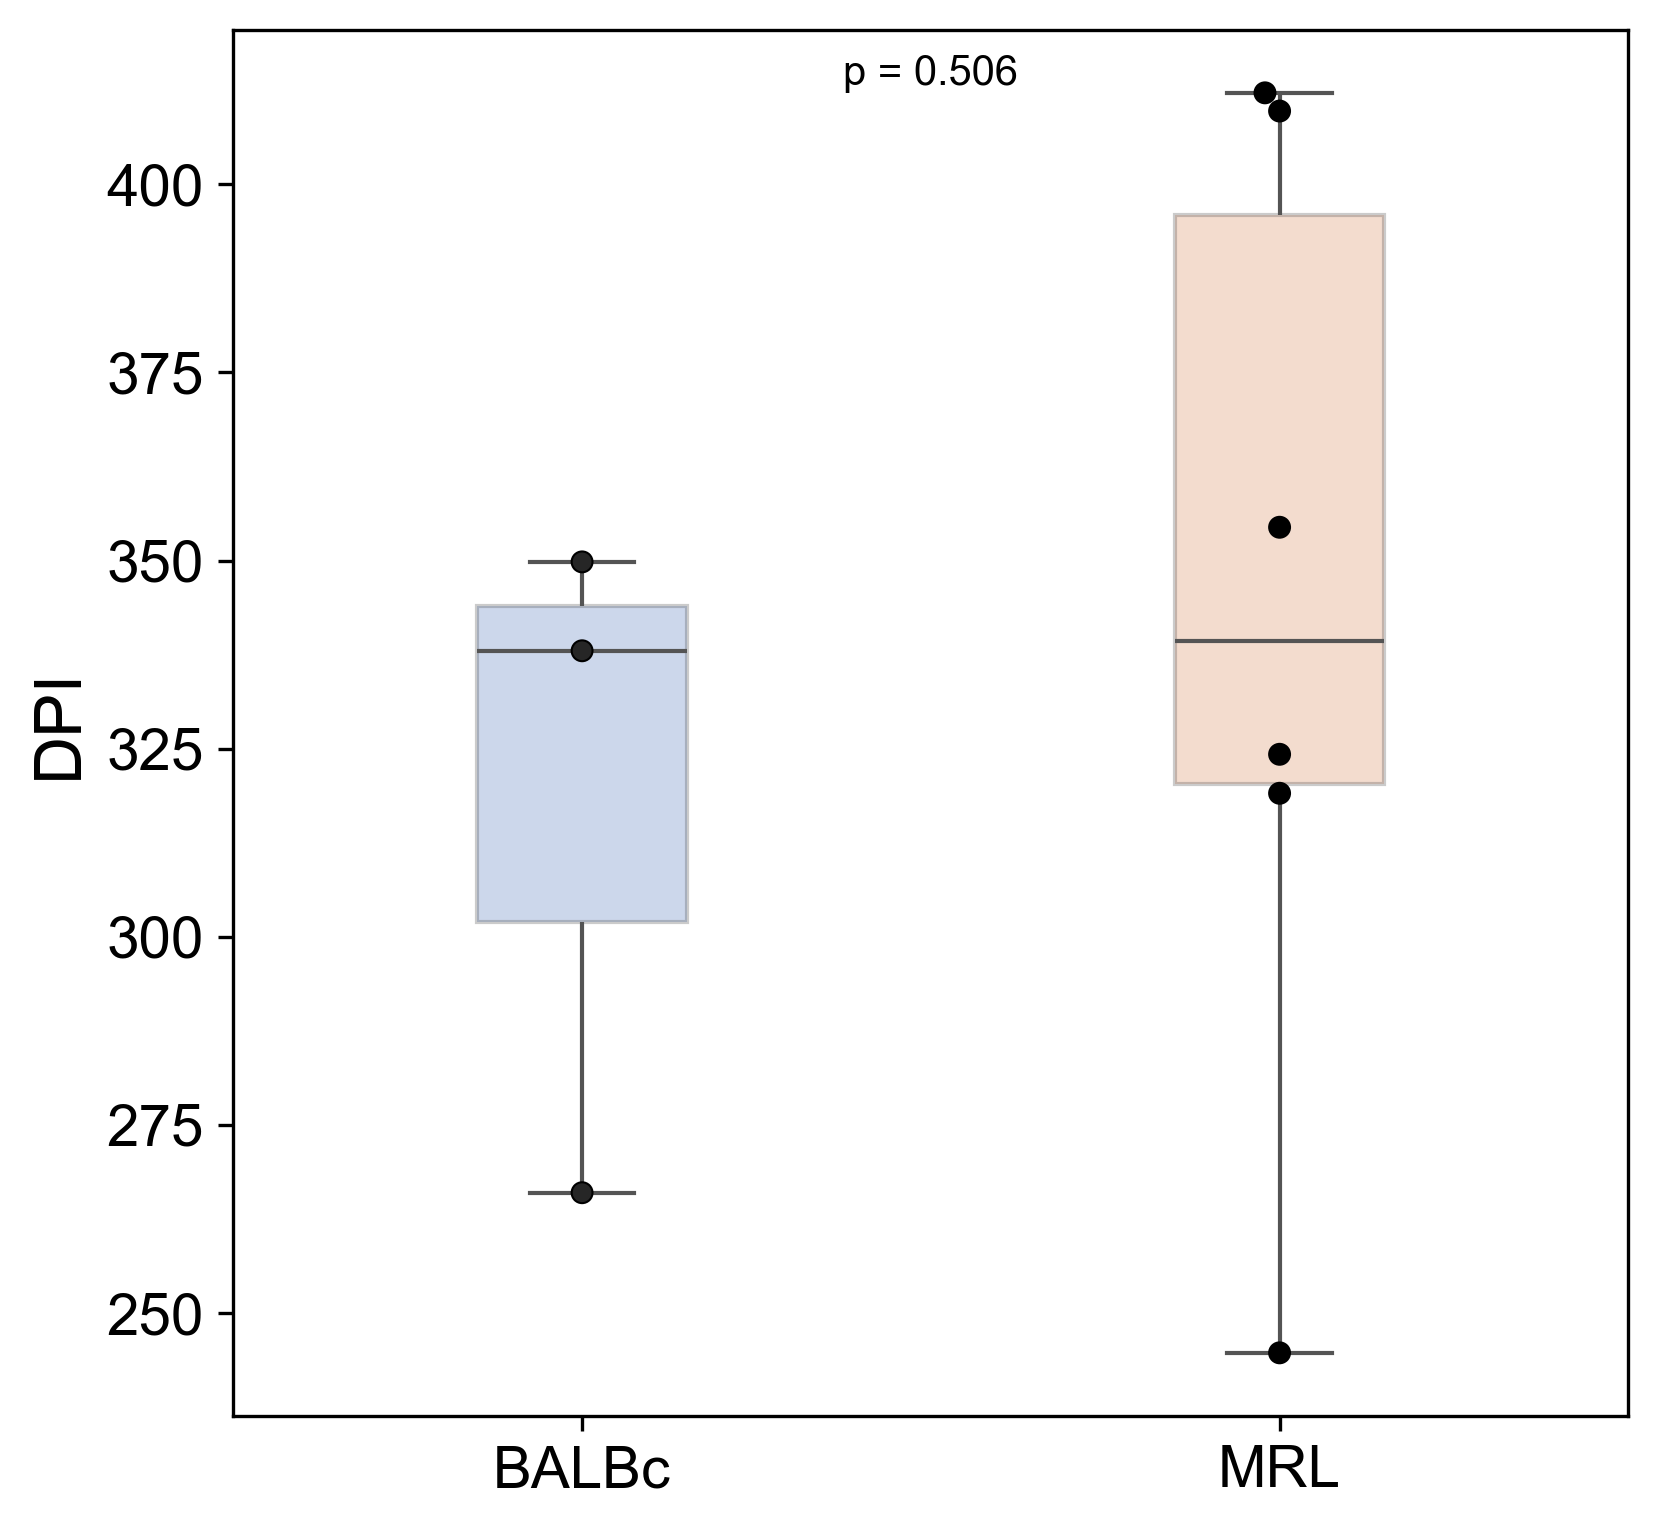

In [23]:
if Hot:
    save_path = mode + f'pvalue{p_value}' + '_HotIslands_Proximity_Index.svg'
else:
    save_path = mode + f'pvalue{p_value}' + '_ColdIslands_Proximity_Index.svg'
    
# Extract data for boxplot
balbc_data = [v[0] for k, v in PX_results[0].items()]
mrl_data = [v[0] for k, v in PX_results[1].items()]

# Mann-Whitney U test
#stat, p_value = stats.mannwhitneyu(balbc_data, mrl_data) # p=0.02381
stat, p_value = stats.ttest_ind(balbc_data, mrl_data,equal_var=False) # p=0.01381

# Combining data
data = [balbc_data, mrl_data]
labels = ['BALBc', 'MRL']

# Plotting
plt.figure(figsize=(6, 6), dpi=300)  # Higher dpi for better resolution
sns.boxplot(data=data, palette="muted", boxprops=dict(alpha=.3), width=0.3)  # Adjusted width here
sns.swarmplot(data=data, palette='dark:black', edgecolor='gray', linewidth=0.5, size=5)


plt.xticks(range(len(labels)), labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("DPI", fontsize=16)
plt.title('', fontsize=18)


# Adding the p-value to the plot
plt.text(0.5, max(balbc_data + mrl_data), f'p = {p_value:.3f}', horizontalalignment='center', verticalalignment='bottom')

fig = plt.gcf()
fig.savefig('../figures/mice/'+save_path)

plt.show()
plt.close(fig)

# Test local G and G* are implemented correctly

In [ ]:
arr1 = np.array([
    [1, 1, 1, 50, 1, 1, 1],
    [1, 1, 1, 50, 1, 1, 1],
    [1, 1, 1, 50, 1, 1, 1],
    [50, 50, 50, 100, 50, 50, 50],
    [1, 1, 1, 50, 1, 1, 1],
    [1, 1, 1, 50, 1, 1, 1],
    [1, 1, 1, 50, 1, 1, 1]
]).astype(float)
arr1

In [ ]:
hotspots, coldspots = msd.local_spatial_stats(arr1, mode='Getis-OrdG', p_value=0.01, tissue_only=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)

hotspots, coldspots = msd.local_spatial_stats(arr1, mode='Getis-OrdG*', p_value=0.01, tissue_only=False)
print(sum(hotspots.flatten()), flush=True)
print(sum(coldspots.flatten()), flush=True)

# Previous Metric sanity check

## global cell frequency

In [18]:
adata_df = adata.obs[['cell_type', 'sample']]
adata_df = adata_df.assign(group=[ 'BALBc' if 'BALBc' in name else 'MRL' for name in adata_df['sample']])

# Filter for desired cell types
selected_cell_types = sorted(adata_df['cell_type'].unique())

filtered_df = adata_df[adata_df['cell_type'].isin(selected_cell_types)]

# Compute cell type frequencies for each sample
global_cell_count = filtered_df.groupby(['sample', 'cell_type']).size().unstack(fill_value=0)
grouped_freq = global_cell_count.div(global_cell_count.sum(axis=1), axis=0)

# Add the group info back to this normalized dataframe
grouped_freq['group'] = [ 'BALBc' if 'BALBc' in name else 'MRL' for name in grouped_freq.index]

# Melt the dataframe for easier plotting and statistical analysis
global_freq = grouped_freq.reset_index().melt(id_vars=['sample', 'group'], value_vars=selected_cell_types)
global_freq.columns = ['sample', 'group', 'cell_type', 'Frequency']

global_freq

,sample,group,cell_type,Frequency
0,BALBc-1,BALBc,B cells,0.426889
1,BALBc-2,BALBc,B cells,0.409448
2,BALBc-3,BALBc,B cells,0.400763
3,MRL-4,MRL,B cells,0.378136
4,MRL-5,MRL,B cells,0.218244
...,...,...,...,...
238,MRL-5,MRL,plasma cells,0.003016
239,MRL-6,MRL,plasma cells,0.013661
240,MRL-7,MRL,plasma cells,0.003686
241,MRL-8,MRL,plasma cells,0.016240


B cells has p value of 0.006408963135728074
B220(+) DN T cells has p value of 0.08363460243637065
CD106(+)CD16/32(+)CD31(+) stroma has p value of 0.10246220899780342
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value of 0.04098951744156447
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value of 0.48760707221130684
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value of 0.00014746290448731814
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value of 0.029644306916028648
CD11c(+) B cells has p value of 0.04433015687789797
CD3(+) other markers (-) has p value of 0.0039461017917897965
CD31(hi) vascular has p value of 0.744873603519344
CD4(+) T cells has p value of 0.23629828012676266
CD4(+)CD8(-)cDC has p value of 0.002101995902806824
CD4(+)MHCII(+) has p value of 0.27737999550550363
CD4(-)CD8(+)cDC has p value of 0.00013225110887609995
CD4(-)CD8(-) cDC has p value of 0.13322938432638706
CD8(+) T cells has p value of 0.8144572874311375
ERTR7(+) stroma has p value of 0.5151830491689221
F4/80(+) mphs has p va

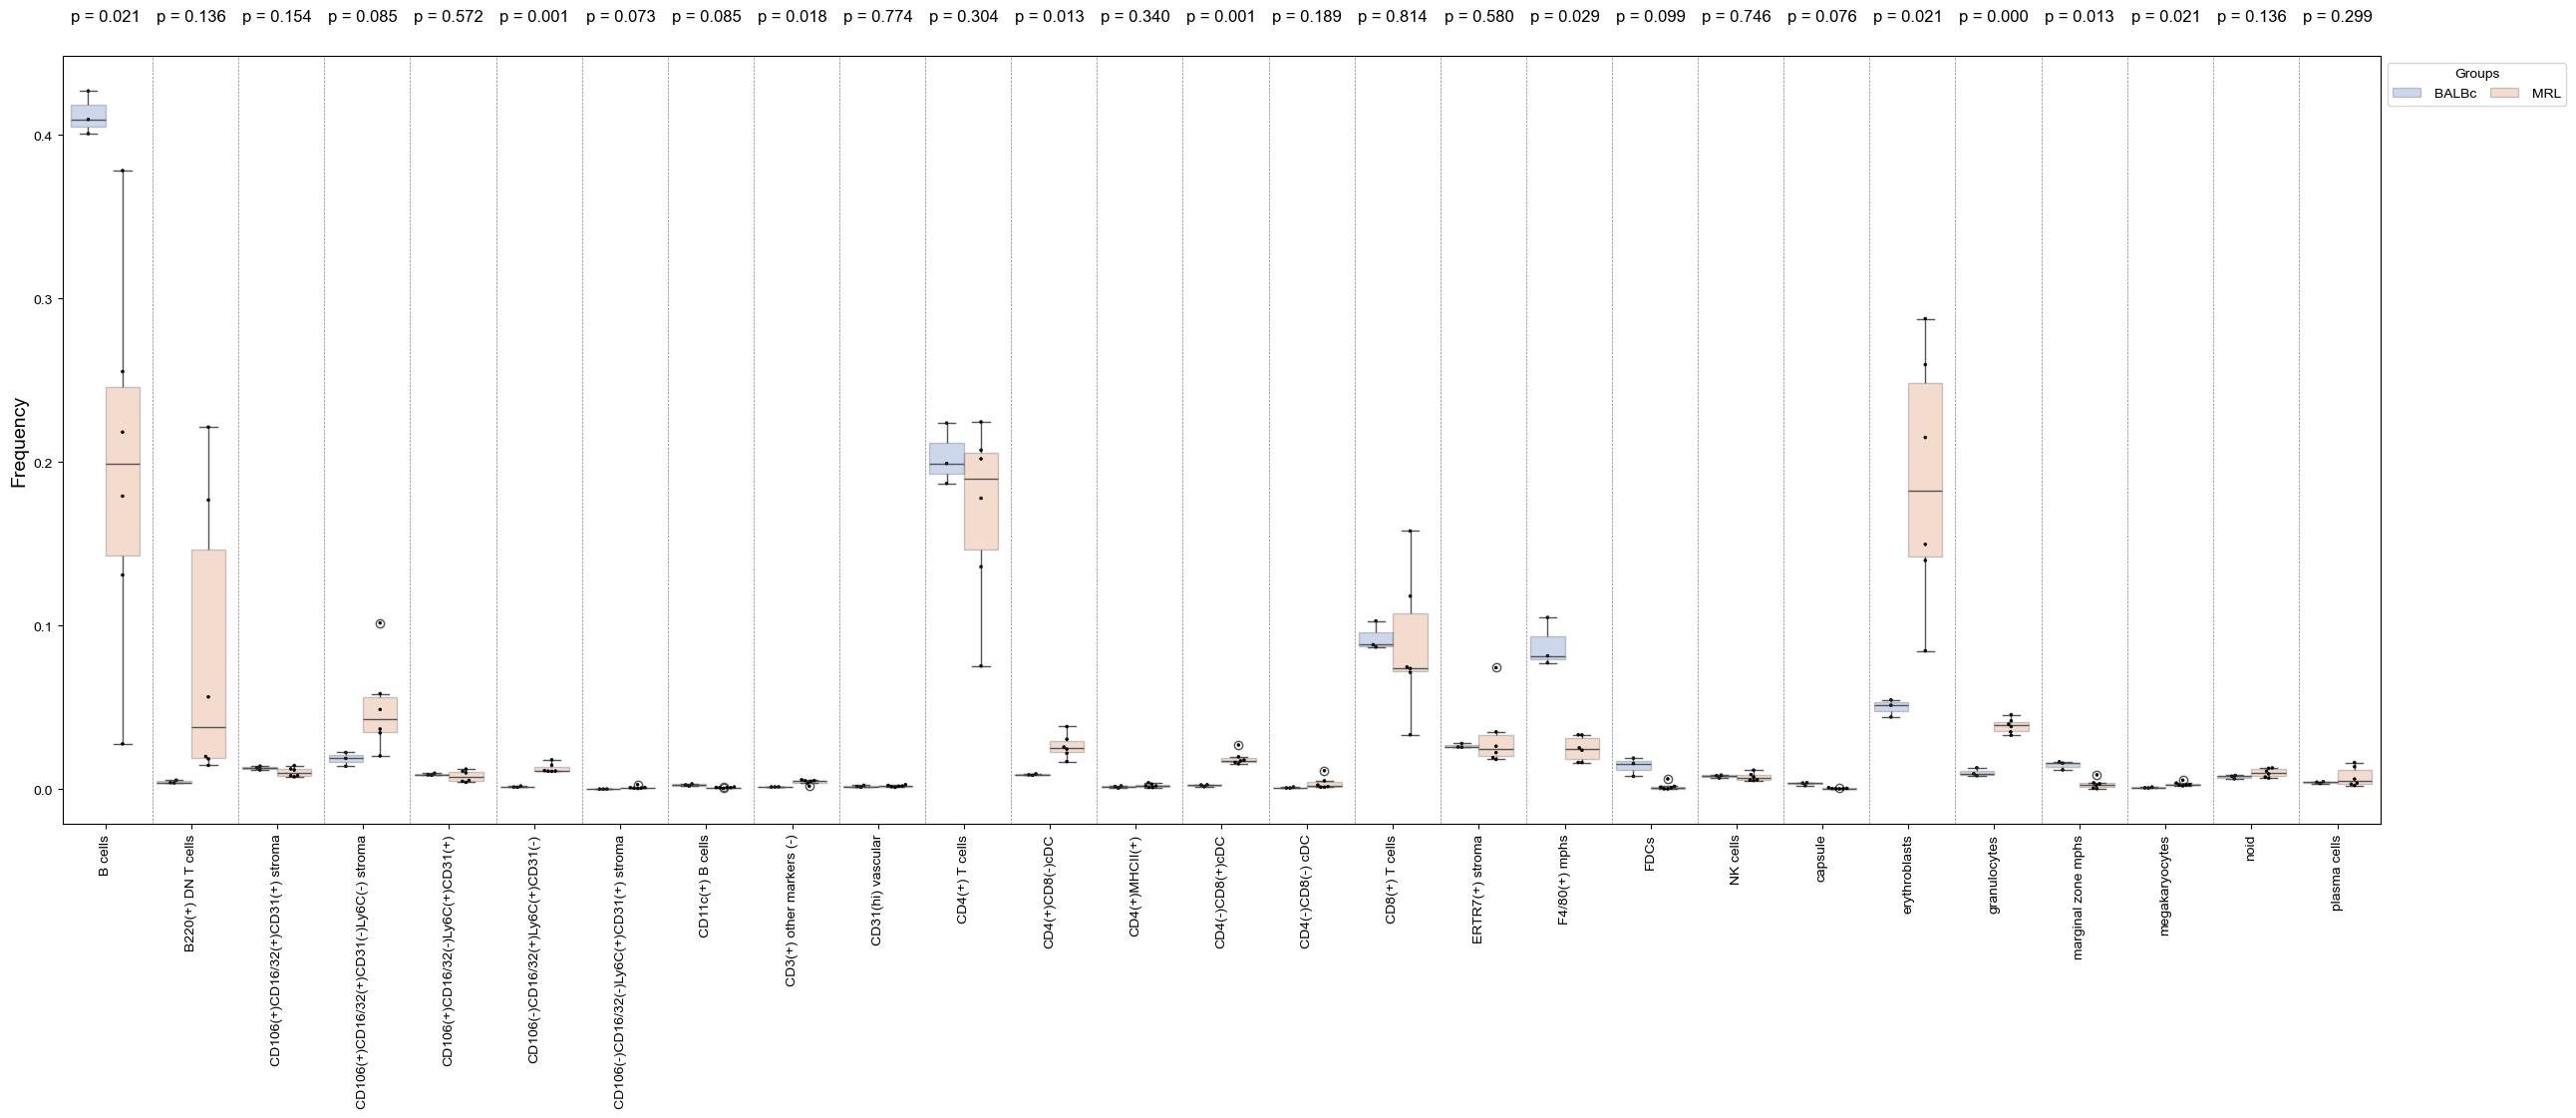

In [19]:
# Perform t-tests
selected_p_values = []
for ct in selected_cell_types:
    group1 = global_freq[(global_freq['cell_type'] == ct) & (global_freq['group'] == 'BALBc')]['Frequency']
    group2 = global_freq[(global_freq['cell_type'] == ct) & (global_freq['group'] == 'MRL')]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value of {p_value}")
    selected_p_values.append(p_value)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
print('-'*42)
print(f"p-values after correction:")

# Plot
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=global_freq, x='cell_type', y='Frequency', hue='group', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=global_freq, x='cell_type', y='Frequency', hue='group', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=90)

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 

# save_path = 'global_celltype_freq.svg'
# plt.savefig('../figures/mice/'+save_path)
plt.show()


## process and visualise cell frequency

In [12]:
df1 = comp_results_mice[0]
df2 = comp_results_mice[1]

# get the union of columns
columns = df1.columns.union(df2.columns)
print(len(columns))

# reindex both dataframes with the union of columns, and fill na with 0
df1 = df1.reindex(columns=columns).fillna(0)
df2 = df2.reindex(columns=columns).fillna(0)

28


In [13]:
df_abundance = pd.concat([df1, df2],axis=0)
df_abundance['Mouse'] = df_abundance.index
df_abundance = df_abundance.drop(columns='noid')

In [14]:
df_abundance

,B cells,B220(+) DN T cells,CD106(+)CD16/32(+)CD31(+) stroma,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,CD106(+)CD16/32(-)Ly6C(+)CD31(+),CD106(-)CD16/32(+)Ly6C(+)CD31(-),CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma,CD11c(+) B cells,CD3(+) other markers (-),CD31(hi) vascular,...,FDCs,NK cells,capsule,erythroblasts,granulocytes,marginal zone mphs,megakaryocytes,plasma cells,Condition,Mouse
BALBc-1,0.301445,0.003322,0.027072,0.044262,0.013287,0.003571,0.000000,0.003156,0.003986,0.001661,...,0.000083,0.019349,0.001827,0.107623,0.024248,0.005066,0.001578,0.010131,BALBc,BALBc-1
BALBc-2,0.273973,0.003664,0.021984,0.033354,0.017751,0.004801,0.000063,0.004738,0.002843,0.002401,...,0.000000,0.016045,0.001516,0.108275,0.028364,0.002716,0.001074,0.011497,BALBc,BALBc-2
BALBc-3,0.282948,0.003704,0.025926,0.029475,0.013966,0.003009,0.000077,0.003009,0.005093,0.003009,...,0.000000,0.017284,0.001235,0.110957,0.025463,0.004938,0.001312,0.012346,BALBc,BALBc-3
MRL-4,0.133904,0.015103,0.015103,0.075633,0.021049,0.022119,0.001427,0.001665,0.009870,0.003449,...,0.000000,0.025211,0.001903,0.151267,0.097515,0.001308,0.004162,0.004162,MRL,MRL-4
MRL-5,0.089479,0.022081,0.006061,0.101602,0.018617,0.018906,0.009237,0.001299,0.006206,0.004041,...,0.000000,0.015442,0.000000,0.114302,0.067975,0.001876,0.012412,0.004474,MRL,MRL-5
MRL-6,0.111169,0.013809,0.014858,0.097011,0.011711,0.040727,0.004370,0.000524,0.017479,0.006992,...,0.000000,0.012061,0.001049,0.170250,0.091942,0.000175,0.003146,0.020276,MRL,MRL-6
MRL-7,0.087740,0.019511,0.006350,0.057723,0.006465,0.016509,0.004387,0.001501,0.007158,0.005195,...,0.000000,0.009813,0.000115,0.176749,0.060956,0.000231,0.004618,0.010852,MRL,MRL-7
MRL-8,0.096830,0.037242,0.007968,0.117616,0.023212,0.013684,0.002079,0.000866,0.009527,0.004331,...,0.000346,0.012992,0.000693,0.117963,0.051273,0.002252,0.006236,0.049887,MRL,MRL-8
MRL-9,0.024049,0.053039,0.025696,0.166035,0.006424,0.048921,0.001153,0.000824,0.003953,0.000988,...,0.000000,0.008401,0.001153,0.172459,0.079723,0.000165,0.004942,0.013507,MRL,MRL-9


In [15]:
# Melt the DataFrame
spot_freq = df_abundance.melt(id_vars=['Mouse', 'Condition'], var_name='CellType', value_name='Frequency')

In [16]:
spot_freq

,Mouse,Condition,CellType,Frequency
0,BALBc-1,BALBc,B cells,0.301445
1,BALBc-2,BALBc,B cells,0.273973
2,BALBc-3,BALBc,B cells,0.282948
3,MRL-4,MRL,B cells,0.133904
4,MRL-5,MRL,B cells,0.089479
...,...,...,...,...
229,MRL-5,MRL,plasma cells,0.004474
230,MRL-6,MRL,plasma cells,0.020276
231,MRL-7,MRL,plasma cells,0.010852
232,MRL-8,MRL,plasma cells,0.049887


p-value before correction:
B cells has p value = 0.0000
B220(+) DN T cells has p value = 0.0139
CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.0097
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.0062
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.9028
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.0112
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value = 0.0295
CD11c(+) B cells has p value = 0.0342
CD3(+) other markers (-) has p value = 0.0460
CD31(hi) vascular has p value = 0.0861
CD4(+) T cells has p value = 0.1443
CD4(+)CD8(-)cDC has p value = 0.0067
CD4(+)MHCII(+) has p value = 0.4478
CD4(-)CD8(+)cDC has p value = 0.0015
CD4(-)CD8(-) cDC has p value = 0.1899
CD8(+) T cells has p value = 0.2234
ERTR7(+) stroma has p value = 0.2324
F4/80(+) mphs has p value = 0.0012
FDCs has p value = 0.6537
NK cells has p value = 0.2228
capsule has p value = 0.0739
erythroblasts has p value = 0.0149
granulocytes has p value = 0.0010
marginal zone mphs has p value = 0.0311
megakaryocy

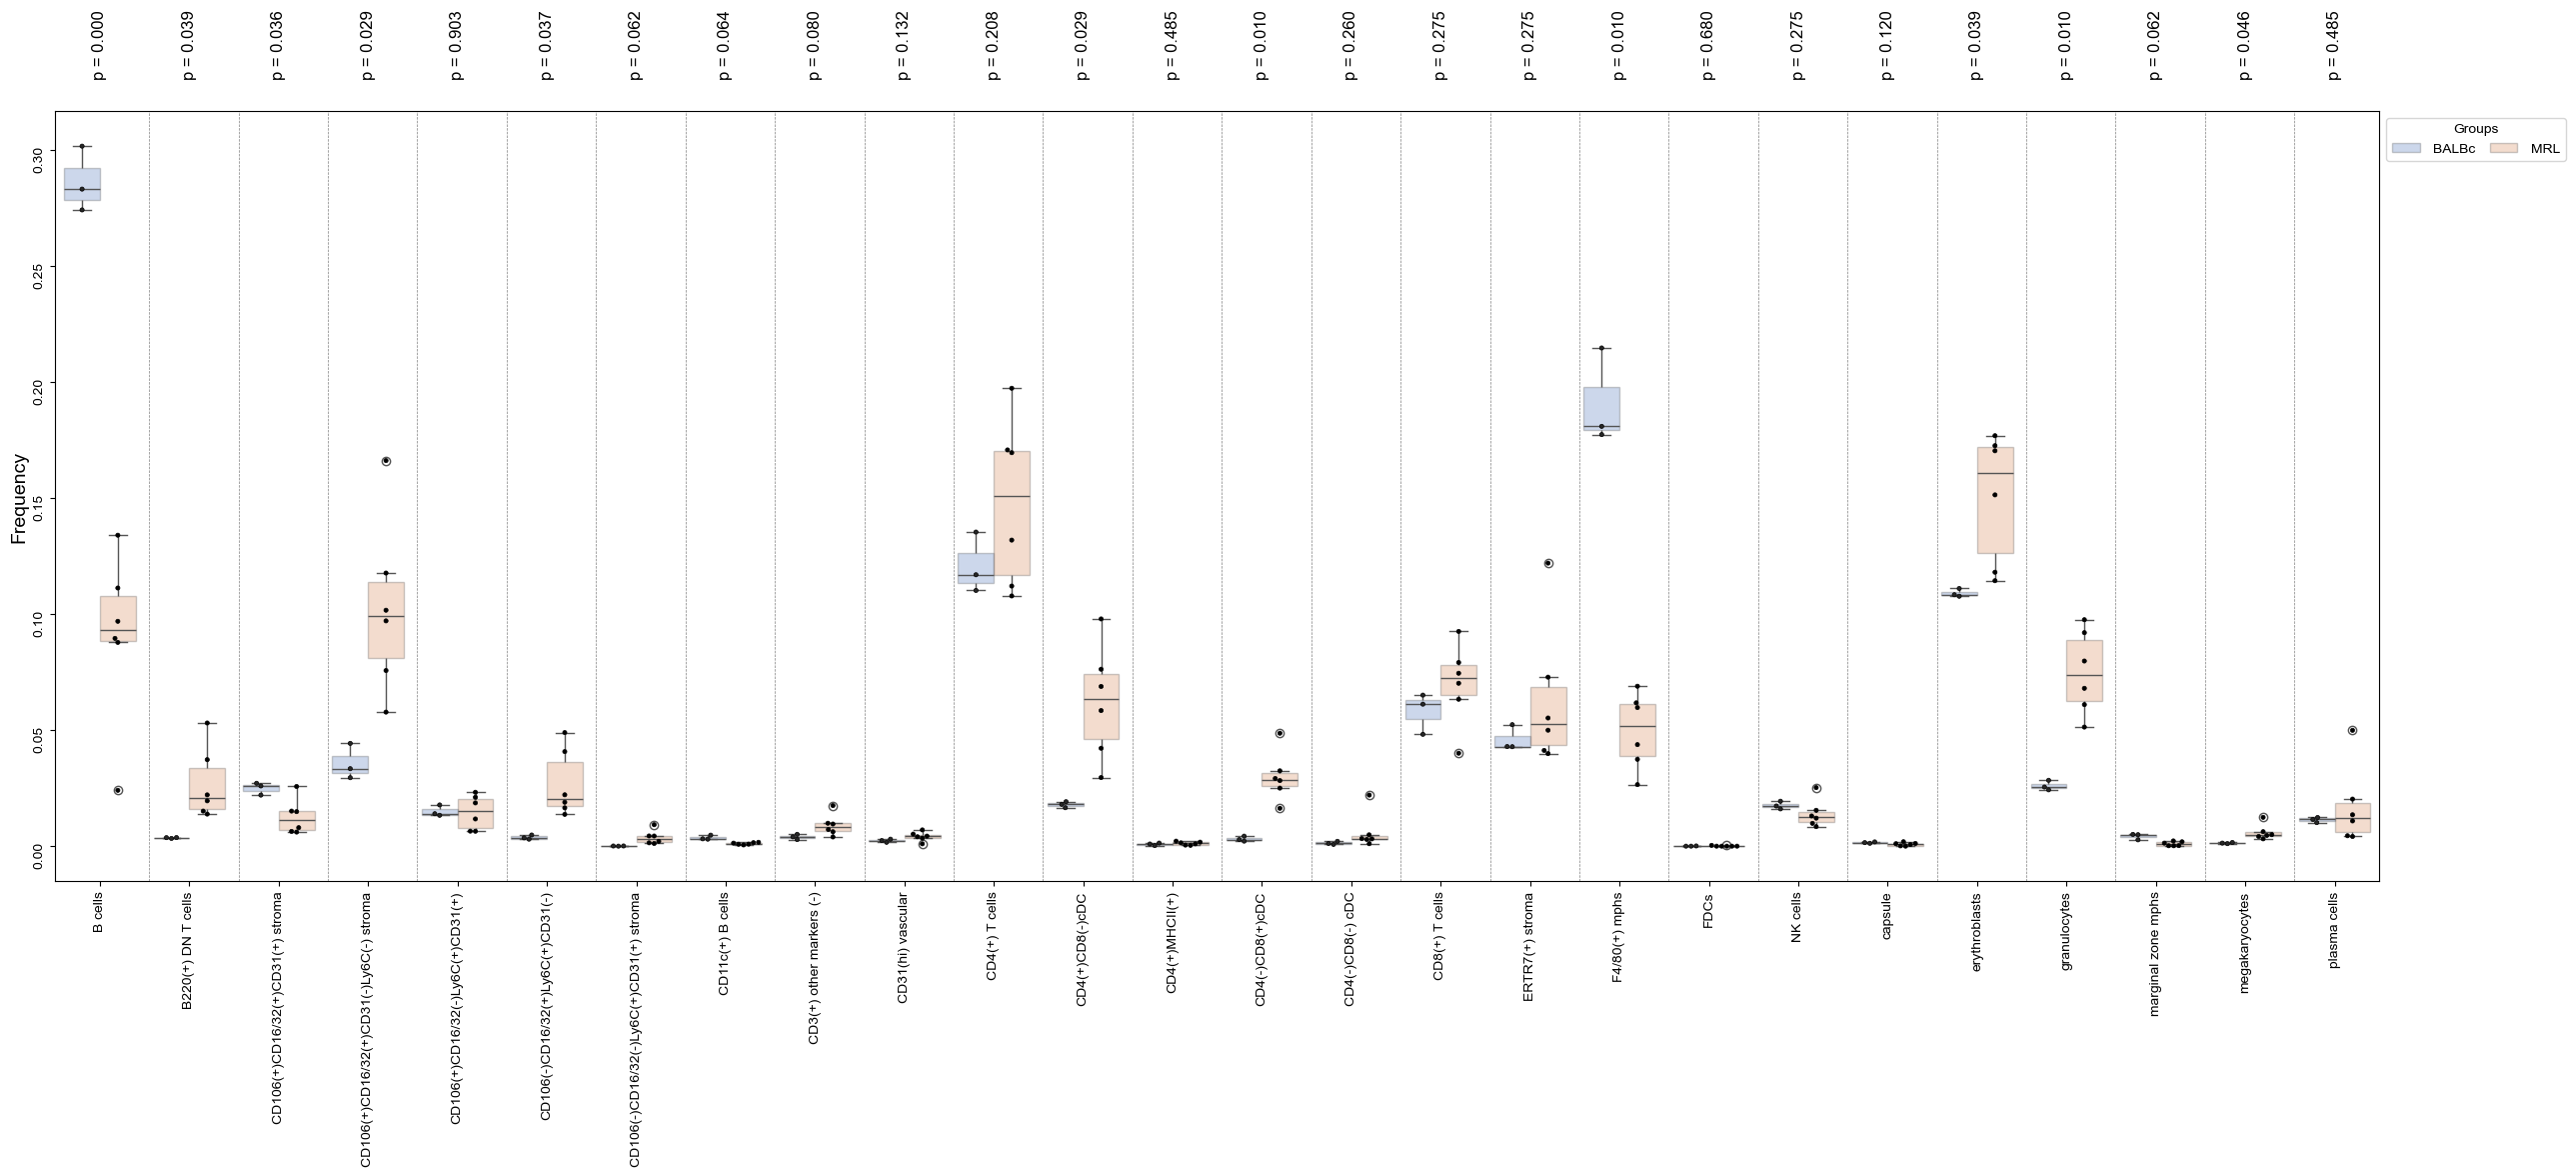

In [20]:
if Hot:
    save_path = 'hotspot_celltype_freq.svg'
else:
    save_path = 'coldspot_celltype_freq.svg'
    
selected_cell_types = sorted(spot_freq['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_freq[spot_freq['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")    
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_freq[spot_freq['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {hot_pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] > 0.05:
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')    
plt.xticks(rotation=90)  
plt.yticks(rotation=90) 
# fig.savefig('../figures/mice/'+save_path)
plt.show()
plt.close(fig)
